In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

# Load the simulation data from the file
data = np.load('simulation_data.npz')
training_data = data['training_data']
testing_data = data['testing_data']

print(training_data.shape)

# Define dimensions based on your data
num_instances = training_data.shape[0]
num_snapshots = training_data.shape[1]
num_points = training_data.shape[2]
num_channels = training_data.shape[3]

(100, 3, 50, 100)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

# Load the simulation data from the file
data = np.load('simulation_data.npz')
training_data = data['training_data']
testing_data = data['testing_data']

# Define dimensions based on your data
num_instances = training_data.shape[0]
num_snapshots = training_data.shape[1]
num_points = training_data.shape[2]
num_channels = training_data.shape[3]

# Prediction parameters
predicted_snapshots = 10

# Ensuring num_snapshots is properly used
if num_snapshots <= predicted_snapshots:
    raise ValueError(f"num_snapshots ({num_snapshots}) must be greater than predicted_snapshots ({predicted_snapshots})")

# Reshape and prepare the data
X_train = training_data[:, :num_snapshots - predicted_snapshots, :, :]
Y_train = training_data[:, -predicted_snapshots:, :, :]
X_test = testing_data[:, :num_snapshots - predicted_snapshots, :, :]
Y_test = testing_data[:, -predicted_snapshots:, :, :]

# Ensure the channels are last
X_train = np.transpose(X_train, (0, 1, 2, 3))
X_test = np.transpose(X_test, (0, 1, 2, 3))
Y_train = np.transpose(Y_train, (0, 1, 2, 3))
Y_test = np.transpose(Y_test, (0, 1, 2, 3))

# Print shapes for sanity
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test.shape)

# Define the model with hyperparameters using Keras Tuner
def build_model(hp):
    model = keras.Sequential([
        layers.Conv2D(
            filters=hp.Int('filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3), activation='relu',
            input_shape=(num_snapshots - predicted_snapshots, num_points, num_channels),
            padding='same'),
        layers.BatchNormalization(),
        layers.Flatten(),
        # Calculate the correct number of units for LSTM input
        layers.Reshape((num_snapshots - predicted_snapshots, num_points * num_channels)),
        layers.LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=True),
        layers.LSTM(hp.Int('lstm_units_2', min_value=32, max_value=128, step=32)),
        layers.Dense(predicted_snapshots * num_points * num_channels),
        # Ensure the output reshape matches the expected output shape
        layers.Reshape((predicted_snapshots, num_points, num_channels))
    ])
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='mse')
    return model

# Hyperparameter tuning
tuner = RandomSearch(build_model, objective='val_loss', max_trials=10, executions_per_trial=1,
    directory='store_best_model',
    project_name='spatio_temporal_model_3D')

# Early stopping to prevent overfitting
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter search
tuner.search(
    X_train, Y_train,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping_callback],
    verbose=1
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate on test data
test_loss = best_model.evaluate(X_test, Y_test, verbose=1)
print(f"Test Loss: {test_loss}")

# Visualization of results
def visualize_comparisons(X_test, Y_test, Y_test_pred, indices, channel_names=["Density", "Velocity", "Temperature"]):
    num_channels = len(channel_names)
    num_instances = len(indices)
    fig, axes = plt.subplots(num_instances, num_channels*2, figsize=(20, num_instances*3))
    
    for idx, sample_index in enumerate(indices):
        for channel_index in range(num_channels):
            # Actual
            ax = axes[idx, channel_index*2]
            actual = X_test[sample_index, :, :, channel_index]
            im = ax.imshow(actual, aspect='auto')
            ax.set_title(f'Actual {channel_names[channel_index]}')
            plt.colorbar(im, ax=ax)
            
            # Prediction
            ax = axes[idx, channel_index*2 + 1]
            prediction = Y_test_pred[sample_index, :, :, channel_index]
            im = ax.imshow(prediction, aspect='auto')
            ax.set_title(f'Predicted {channel_names[channel_index]}')
            plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

# Select some indices to visualize
indices_to_visualize = [0, 10, 32]

# Assuming Y_test_pred has been reshaped correctly as per previous steps
visualize_comparisons(X_test, Y_test, Y_test_pred, indices_to_visualize)


ValueError: num_snapshots (3) must be greater than predicted_snapshots (10)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

# Load the simulation data from the file
data = np.load('simulation_data.npz')
training_data = data['training_data']
testing_data = data['testing_data']

# Define dimensions based on your data
num_instances = training_data.shape[0]
num_channels = training_data.shape[1]
num_snapshots = training_data.shape[2]
num_points = training_data.shape[3]

# Prediction parameters
predicted_snapshots = 10  # How many future snapshots to predict

# Preparing the data for training and testing
# Extracting features and labels from the training data
X_train = training_data[:, :, :num_snapshots - predicted_snapshots, :]
Y_train = training_data[:, :, -predicted_snapshots:, :]
X_test = testing_data[:, :, :num_snapshots - predicted_snapshots, :]
Y_test = testing_data[:, :, -predicted_snapshots:, :]

# Print shapes for sanity
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

# Define the model with hyperparameters using Keras Tuner
def build_model(hp):
    model = keras.Sequential([
        layers.Conv3D(
            filters=hp.Int('filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3, 3), activation='relu',
            input_shape=(num_channels, num_snapshots - predicted_snapshots, num_points, 1),
            padding='same'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'),
        layers.Reshape((num_channels, predicted_snapshots, num_points, 1)),  # Reshape output to match Y_train
        layers.Conv3D(filters=1, kernel_size=(1, 1, 1), activation='linear')
    ])
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='mse')
    return model

# Hyperparameter tuning setup
tuner = RandomSearch(build_model, objective='val_loss', max_trials=10, executions_per_trial=1,
    directory='store_best_model', project_name='spatio_temporal_model_3D')

# Early stopping to prevent overfitting
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter search
tuner.search(
    X_train, Y_train,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping_callback],
    verbose=1
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate on test data
test_loss = best_model.evaluate(X_test, Y_test, verbose=1)
print(f"Test Loss: {test_loss}")

# Visualization and further analysis here...

Shape of X_train: (100, 3, 40, 100)
Shape of Y_train: (100, 3, 10, 100)
Shape of X_test: (100, 3, 40, 100)
Shape of Y_test: (100, 3, 10, 100)
Reloading Tuner from store_best_model\spatio_temporal_model_3D\tuner0.json


ValueError: Exception encountered when calling layer "reshape" (type Reshape).

total size of new array must be unchanged, input_shape = [64], output_shape = [3, 10, 100, 1]

Call arguments received by layer "reshape" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 64), dtype=float32)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 3, 50, 100)  0           []                               
                                ]                                                                 
                                                                                                  
 lambda_18 (Lambda)             (None, 50, 100)      0           ['input_7[0][0]']                
                                                                                                  
 lambda_19 (Lambda)             (None, 50, 100)      0           ['input_7[0][0]']                
                                                                                                  
 lambda_20 (Lambda)             (None, 50, 100)      0           ['input_7[0][0]']          

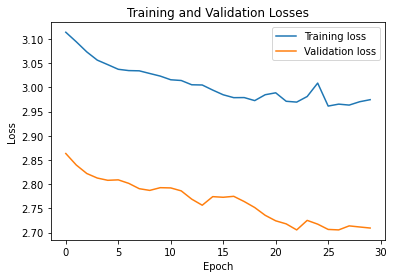

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the simulation data from the file
data = np.load('simulation_data.npz')
training_data = data['training_data']
testing_data = data['testing_data']

# Define dimensions based on your data
num_instances = training_data.shape[0]
num_channels = training_data.shape[1]
num_snapshots = training_data.shape[2]
num_points = training_data.shape[3]
predicted_snapshots = 10  # define how many future snapshots you want to predict

def create_model():
    # Input shape: (num_channels, num_snapshots, num_points)
    input_layer = keras.Input(shape=(num_channels, num_snapshots, num_points))

    # Process each channel with its own CNN
    processed_channels = []
    for i in range(num_channels):
        # Slice the input to get each channel's data separately
        channel_input = layers.Lambda(lambda x: x[:, i])(input_layer)
        channel_input = layers.Reshape((num_snapshots, num_points, 1))(channel_input)  # Add channel dimension for CNN

        # CNN layers to extract spatial features from each snapshot
        cnn = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(channel_input)
        cnn = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)
        cnn = layers.BatchNormalization()(cnn)
        cnn = layers.MaxPooling2D((2, 2))(cnn)
        cnn = layers.Flatten()(cnn)

        # Prepare CNN output for LSTM input
        cnn = layers.Reshape((num_snapshots, -1))(cnn)
        processed_channels.append(cnn)

    # Concatenate processed channels
    concatenated = layers.Concatenate(axis=-1)(processed_channels)

    # LSTM layers to analyze temporal data
    lstm = layers.LSTM(128, return_sequences=True)(concatenated)
    lstm = layers.LSTM(64, return_sequences=False)(lstm)

    # Dense layer to predict future snapshots
    dense = layers.Dense(predicted_snapshots * num_points * num_channels, activation='relu')(lstm)
    output_layer = layers.Reshape((num_channels, predicted_snapshots, num_points))(dense)

    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')

    return model

# Instantiate and compile the model
model = create_model()
model.summary()

# Train the model
history = model.fit(
    training_data,  # Ensure training_data is appropriately reshaped if needed
    training_data[:, :, -predicted_snapshots:, :],  # Use the last 'predicted_snapshots' from training_data as labels
    epochs=30,
    batch_size=32,
    validation_split=0.2
)

# Evaluate the model on the test data
test_loss = model.evaluate(
    testing_data,  # Ensure testing_data is appropriately reshaped if needed
    testing_data[:, :, -predicted_snapshots:, :]  # Use the last 'predicted_snapshots' from testing_data as labels
)
print('Test Loss:', test_loss)

# Optionally, visualize training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/30
3/3 [==============================] - 4s 1s/step - loss: 1.1262 - val_loss: 0.9198 - lr: 0.0010
Epoch 2/30
3/3 [==============================] - 4s 1s/step - loss: 1.0599 - val_loss: 0.9184 - lr: 0.0010
Epoch 3/30
3/3 [==============================] - 4s 1s/step - loss: 1.0382 - val_loss: 0.8833 - lr: 0.0010
Epoch 4/30
3/3 [==============================] - 3s 1s/step - loss: 1.0379 - val_loss: 0.8775 - lr: 0.0010
Epoch 5/30
3/3 [==============================] - 4s 1s/step - loss: 1.0283 - val_loss: 0.8778 - lr: 0.0010
Epoch 6/30
3/3 [==============================] - 4s 1s/step - loss: 1.0228 - val_loss: 0.8753 - lr: 0.0010
Epoch 7/30
3/3 [==============================] - 3s 1s/step - loss: 1.0221 - val_loss: 0.8751 - lr: 0.0010
Epoch 8/30
3/3 [==============================] - 3s 1s/step - loss: 1.0181 - val_loss: 0.8750 - lr: 0.0010
Epoch 9/30
3/3 [==============================] - 3s 1s/step - loss: 1.0171 - val_loss: 0.8780 - lr: 0.0010
Epoch 10/30
3/3 [===========

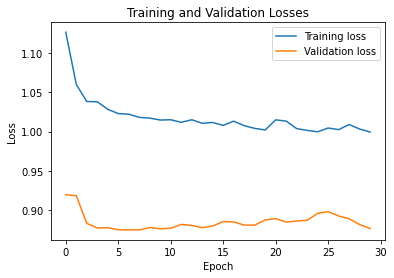

In [24]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Function to decay the learning rate
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

lr_callback = LearningRateScheduler(scheduler)

# Normalize your data (if not already normalized)
# Ensure that the normalization is done per feature across all snapshots
mean = training_data.mean(axis=(0, 2), keepdims=True)
std = training_data.std(axis=(0, 2), keepdims=True)
training_data_normalized = (training_data - mean) / std
testing_data_normalized = (testing_data - mean) / std

# Train the model
history = model.fit(
    training_data_normalized,
    training_data_normalized[:, :, -predicted_snapshots:, :],  # Labels are normalized too
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr_callback]  # Add the learning rate scheduler callback
)

# Evaluate on test data (also normalized)
test_loss = model.evaluate(
    testing_data_normalized,
    testing_data_normalized[:, :, -predicted_snapshots:, :]  # Labels are normalized too
)
print('Test Loss:', test_loss)

# Plot training history
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 3, 50, 100)  0           []                               
                                ]                                                                 
                                                                                                  
 lambda_21 (Lambda)             (None, 50, 100)      0           ['input_8[0][0]']                
                                                                                                  
 lambda_22 (Lambda)             (None, 50, 100)      0           ['input_8[0][0]']                
                                                                                                  
 lambda_23 (Lambda)             (None, 50, 100)      0           ['input_8[0][0]']          

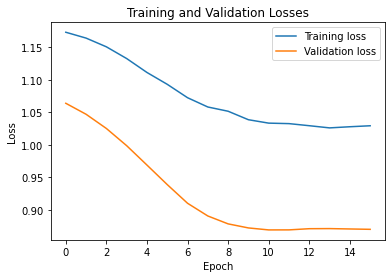

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt

# Load the simulation data from the file
data = np.load('simulation_data.npz')
training_data = data['training_data']
testing_data = data['testing_data']

# Define dimensions based on your data
num_instances = training_data.shape[0]
num_channels = training_data.shape[1]
num_snapshots = training_data.shape[2]
num_points = training_data.shape[3]
predicted_snapshots = 10  # define how many future snapshots you want to predict

# Function to normalize data
def normalize_data(data):
    mean = data.mean(axis=(0, 2), keepdims=True)
    std = data.std(axis=(0, 2), keepdims=True)
    return (data - mean) / std

# Normalize the training and testing data
training_data_normalized = normalize_data(training_data)
testing_data_normalized = normalize_data(testing_data)

# Function to create the model with dropout for regularization
def create_model_with_dropout():
    input_layer = keras.Input(shape=(num_channels, num_snapshots, num_points))

    processed_channels = []
    for i in range(num_channels):
        channel_input = layers.Lambda(lambda x: x[:, i])(input_layer)
        channel_input = layers.Reshape((num_snapshots, num_points, 1))(channel_input)

        cnn = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(channel_input)
        cnn = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)
        cnn = layers.BatchNormalization()(cnn)
        cnn = layers.MaxPooling2D((2, 2))(cnn)
        cnn = layers.Flatten()(cnn)
        cnn = layers.Reshape((num_snapshots, -1))(cnn)
        processed_channels.append(cnn)

    concatenated = layers.Concatenate(axis=-1)(processed_channels)

    lstm = layers.LSTM(128, return_sequences=True)(concatenated)
    lstm = layers.Dropout(0.5)(lstm)
    lstm = layers.LSTM(64, return_sequences=False)(lstm)
    lstm = layers.Dropout(0.5)(lstm)

    dense = layers.Dense(predicted_snapshots * num_points * num_channels, activation='relu')(lstm)
    output_layer = layers.Reshape((num_channels, predicted_snapshots, num_points))(dense)

    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the model
model = create_model_with_dropout()
model.summary()

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Set up callbacks
lr_callback = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    training_data_normalized,
    training_data_normalized[:, :, -predicted_snapshots:, :],
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr_callback, early_stopping]
)

# Evaluate on test data
test_loss = model.evaluate(
    testing_data_normalized,
    testing_data_normalized[:, :, -predicted_snapshots:, :]
)
print('Test Loss:', test_loss)

# Visualize the training and validation losses
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

4/4 [==============================] - 2s 156ms/step
Mean Squared Error (MSE) on Test Data: 2.9735658307080195
Mean Absolute Error (MAE) on Test Data: 1.068410292017896
R-squared (R²) on Test Data: -9.670972802829326


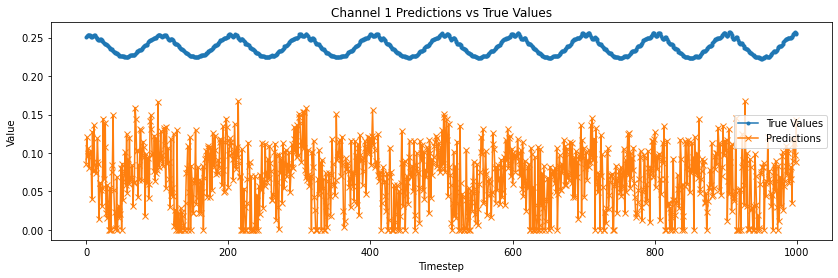

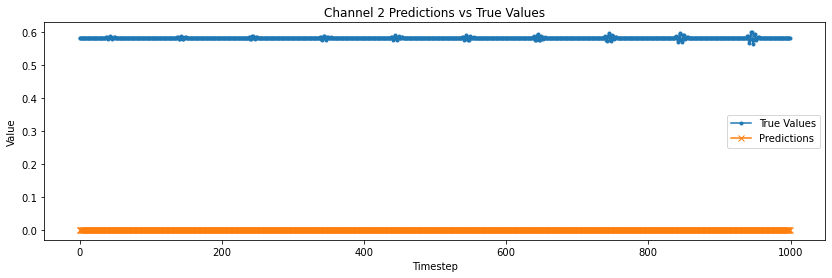

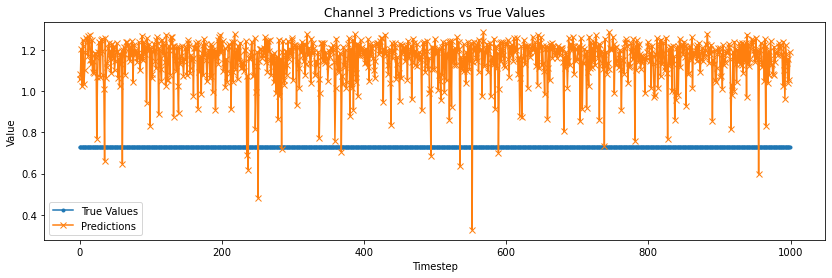

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the test data
test_predictions = model.predict(testing_data_normalized)

# Reshape the predictions and true values for evaluation
y_true = testing_data[:, :, -predicted_snapshots:, :].reshape(-1, num_channels * predicted_snapshots * num_points)
y_pred = test_predictions.reshape(-1, num_channels * predicted_snapshots * num_points)

# Calculate evaluation metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE) on Test Data: {mse}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")
print(f"R-squared (R²) on Test Data: {r2}")

# Visualize the predictions against the true values
# We will visualize one sample for each channel
for i in range(num_channels):
    plt.figure(figsize=(14, 4))
    
    # Select a random test sample index
    sample_index = np.random.randint(low=0, high=testing_data_normalized.shape[0])
    
    # Plot the true values
    plt.plot(y_true[sample_index, i * predicted_snapshots * num_points:(i + 1) * predicted_snapshots * num_points], label='True Values', marker='.')
    
    # Plot the predicted values
    plt.plot(y_pred[sample_index, i * predicted_snapshots * num_points:(i + 1) * predicted_snapshots * num_points], label='Predictions', marker='x')
    
    # Titles and labels
    plt.title(f'Channel {i + 1} Predictions vs True Values')
    plt.xlabel('Timestep')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_56 (InputLayer)          [(None, 3, 50, 100)  0           []                               
                                ]                                                                 
                                                                                                  
 lambda_105 (Lambda)            (None, 50, 100)      0           ['input_56[0][0]']               
                                                                                                  
 lambda_106 (Lambda)            (None, 50, 100)      0           ['input_56[0][0]']               
                                                                                                  
 lambda_107 (Lambda)            (None, 50, 100)      0           ['input_56[0][0]']        

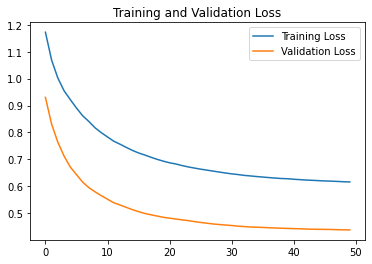

In [100]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt

# Load the simulation data
data = np.load('simulation_data.npz')
training_data = data['training_data']
testing_data = data['testing_data']

# Define dimensions
num_instances = training_data.shape[0]
num_channels = training_data.shape[1]
num_snapshots = training_data.shape[2]
num_points = training_data.shape[3]
predicted_snapshots = 10  # How many future snapshots to predict

# Normalize the data
mean = training_data.mean(axis=(0, 2), keepdims=True)
std = training_data.std(axis=(0, 2), keepdims=True)
training_data_normalized = (training_data - mean) / std
testing_data_normalized = (testing_data - mean) / std

# Seq2Seq Model Creation
def create_seq2seq_model():
    # Encoder
    encoder_inputs = keras.Input(shape=(num_channels, num_snapshots, num_points))
    processed_channels = []
    for i in range(num_channels):
        channel_input = layers.Lambda(lambda x: x[:, i, :, :])(encoder_inputs)
        channel_input = layers.Reshape((num_snapshots, num_points, 1))(channel_input)
        cnn = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(channel_input)
        cnn = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)
        cnn = layers.BatchNormalization()(cnn)
        cnn = layers.MaxPooling2D((2, 2))(cnn)
        cnn = layers.Flatten()(cnn)
        cnn = layers.Reshape((num_snapshots, -1))(cnn)
        processed_channels.append(cnn)

    encoder_concat = layers.Concatenate(axis=-1)(processed_channels)
    encoder_outputs, state_h, state_c = layers.LSTM(128, return_state=True)(encoder_concat)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = keras.Input(shape=(predicted_snapshots, num_points * num_channels))
    decoder_lstm = layers.LSTM(128, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = layers.TimeDistributed(layers.Dense(num_points * num_channels, activation='relu'))
    decoder_outputs = decoder_dense(decoder_outputs)
    output_layer = layers.Reshape((num_channels, predicted_snapshots, num_points))(decoder_outputs)

    model = keras.Model([encoder_inputs, decoder_inputs], output_layer)
    model.compile(optimizer='adam', loss='mse')
    return model

# Instantiate and compile the model
model = create_seq2seq_model()
model.summary()

# Prepare the decoder input data, it should be the last known snapshot used to start the prediction process
decoder_input_data = training_data_normalized[:, :, -predicted_snapshots:, :].reshape(num_instances, predicted_snapshots, -1)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Function that updates the learning rate
def lr_schedule(epoch, lr):
    if epoch > 10 and epoch % 2 == 0:
        lr = lr * tf.math.exp(-0.1)
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

history = model.fit(
    [training_data_normalized, decoder_input_data],  # Real decoder input needs to be defined
    training_data_normalized[:, :, -predicted_snapshots:, :],
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model on the test data
test_loss = model.evaluate(
    [testing_data_normalized, decoder_input_data],  # Real test decoder input needs to be defined
    testing_data_normalized[:, :, -predicted_snapshots:, :],
    verbose=0
)
print('Test Loss:', test_loss)

# Visualization of training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

4/4 [==============================] - 6s 627ms/step


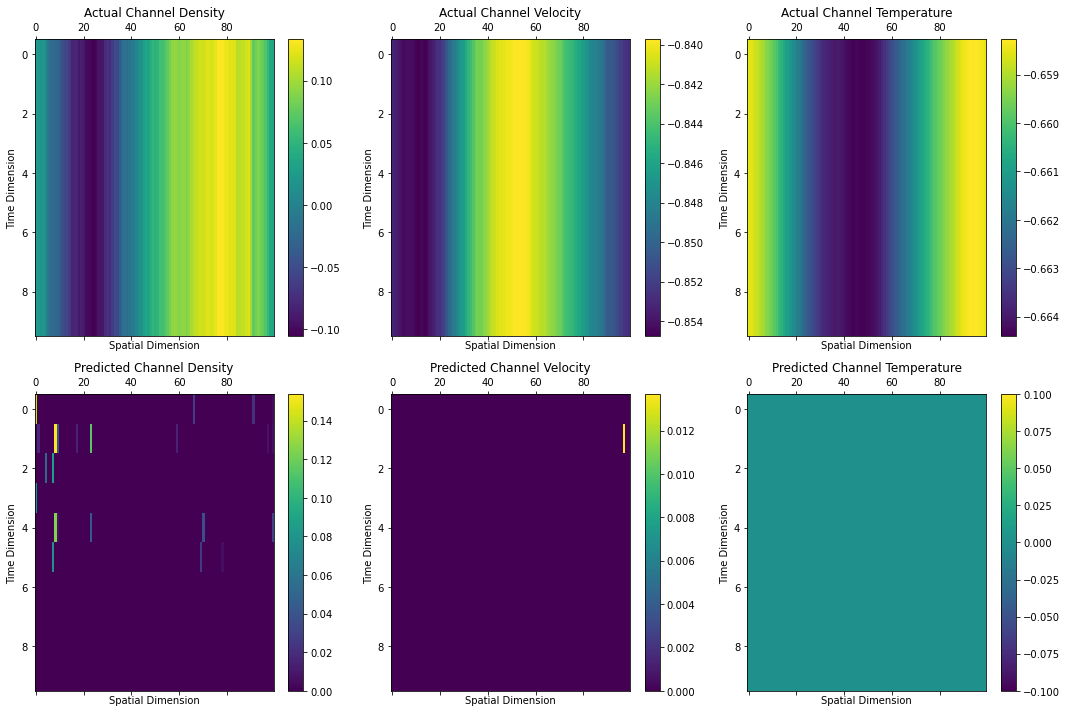

Mean Squared Error (MSE) on Test Data: 1.8362733294694098
Mean Absolute Error (MAE) on Test Data: 0.9749100942037855
R-squared (R²) on Test Data: -0.48777992114708757


In [101]:
# Predictions and Visualization
def plot_actual_vs_predicted(sample_index, actual, predicted, num_channels):
    fig, axes = plt.subplots(nrows=2, ncols=num_channels, figsize=(15,10))  # Adjust the figure size as needed

    field_names = ['Density', 'Velocity', 'Temperature']
    # Plot actual heatmaps
    for i in range(num_channels):
        ax = axes[0, i]
        cax = ax.matshow(actual[sample_index, i, -predicted_snapshots:, :], aspect='auto')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'Actual Channel {field_names[i]}')
        ax.set_xlabel('Spatial Dimension')
        ax.set_ylabel('Time Dimension')

    # Plot predicted heatmaps
    for i in range(num_channels):
        ax = axes[1, i]
        cax = ax.matshow(predicted[sample_index, i, -predicted_snapshots:, :], aspect='auto')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'Predicted Channel {field_names[i]}')
        ax.set_xlabel('Spatial Dimension')
        ax.set_ylabel('Time Dimension')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
actual_data = testing_data_normalized[:, :, -predicted_snapshots:, :]
predicted_outputs = model.predict([testing_data_normalized, decoder_input_data])

# Sample index to visualize
sample_index = np.random.randint(0, num_instances)

plot_actual_vs_predicted(sample_index, actual_data, predicted_outputs, num_channels)

#####################################################################################
#####################################################################################
#####################################################################################

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Reshape the predictions and true values for evaluation
actual_data_metrics_test = actual_data.reshape(-1, num_channels * predicted_snapshots * num_points)
predicted_outputs_metrics_test = predicted_outputs.reshape(-1, num_channels * predicted_snapshots * num_points)

# Calculate evaluation metrics
mse = mean_squared_error(actual_data_metrics_test, predicted_outputs_metrics_test)
mae = mean_absolute_error(actual_data_metrics_test, predicted_outputs_metrics_test)
r2 = r2_score(actual_data_metrics_test, predicted_outputs_metrics_test)

print(f"Mean Squared Error (MSE) on Test Data: {mse}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")
print(f"R-squared (R²) on Test Data: {r2}")


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the simulation data
data = np.load('simulation_data.npz')
training_data = data['training_data']
testing_data = data['testing_data']

# Define dimensions based on your data
num_instances = training_data.shape[0]
num_channels = training_data.shape[1]
num_snapshots = training_data.shape[2]
num_points = training_data.shape[3]

# Normalize the data
mean = np.mean(training_data, axis=(0, 2, 3), keepdims=True)
std = np.std(training_data, axis=(0, 2, 3), keepdims=True)

training_data_normalized = (training_data - mean) / std
testing_data_normalized = (testing_data - mean) / std

# Model architecture
model = keras.Sequential([
    # Input layer
    layers.Input(shape=(num_channels, num_snapshots, num_points)),
    # Reshape to data to optimal shape for 1D CNN
    layers.Reshape((num_snapshots, num_points, num_channels)),
    # 1D CNN for Spatial Feature Extraction
    layers.TimeDistributed(layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')),
    # Reshape to combine channels after 1D Conv
    layers.Reshape((num_snapshots, num_points * 32)),
    # Reshape for applying 2D convolutions, treating each time snapshot as an individual "image"
    layers.Reshape((num_snapshots, num_points, 32, 1)),
    # 2D CNN for Combined Spatial Features
    layers.TimeDistributed(layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')),
    # Flatten to feed into LSTM
    layers.Reshape((num_snapshots, -1)),
    # LSTM for Temporal Analysis
    layers.LSTM(64),
    # Dense Layer for Output
    layers.Dense(num_channels * num_snapshots * num_points),
    # Reshape to output shape
    layers.Reshape((num_channels, num_snapshots, num_points))
])

# Print model summary for debugging
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 50, 100, 3)        0         
                                                                 
 time_distributed_2 (TimeDis  (None, 50, 100, 32)      320       
 tributed)                                                       
                                                                 
 reshape_6 (Reshape)         (None, 50, 3200)          0         
                                                                 
 reshape_7 (Reshape)         (None, 50, 100, 32, 1)    0         
                                                                 
 time_distributed_3 (TimeDis  (None, 50, 100, 32, 64)  640       
 tributed)                                                       
                                                                 
 reshape_8 (Reshape)         (None, 50, 204800)       

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduction factor; new_lr = lr * factor
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,  # Lower bound on the learning rate
    verbose=1  # If set to 1, the method will print messages when reducing the learning rate
)

# Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

# Compile the model
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# Fit the model with the learning rate scheduler
history = model.fit(
    training_data_normalized, 
    training_data_normalized,  # Replace with actual targets if different from the input
    epochs=100,
    batch_size=32, 
    validation_split=0.2,
    callbacks=[reduce_lr, early_stopping]  # Add early_stopping if you wish to use it
)

# Plot the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/100
1/3 [=========>....................] - ETA: 1:16 - loss: 0.7324


KeyboardInterrupt



In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict using the model on the testing data
predictions = model.predict(testing_data_normalized)

# Reshape predictions and testing data if needed, then calculate evaluation metrics
# Flatten the arrays to compare every element
predictions_flat = predictions.reshape(-1)
testing_data_flat = testing_data_normalized.reshape(-1)

mse = mean_squared_error(testing_data_flat, predictions_flat)
mae = mean_absolute_error(testing_data_flat, predictions_flat)
r2 = r2_score(testing_data_flat, predictions_flat)

# Print out the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R^2 Score: {r2}')

4/4 [==============================] - 13s 3s/step
MSE: 2.878809320863815
MAE: 1.0432190356195943
R^2 Score: 0.04748362675862439


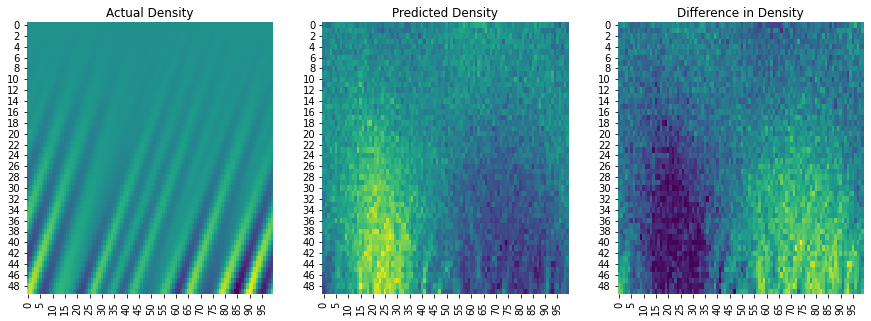

In [15]:
# Visualization function for heatmaps
def plot_heatmaps(actual, predicted, snapshot_num):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    # Ensure that the predicted data is reshaped to match the actual data dimensions
    predicted_reshaped = predicted.reshape(actual.shape)
    
    sns.heatmap(actual[0, snapshot_num, :, :], ax=axes[0], cbar=False, cmap='viridis')
    axes[0].set_title('Actual Density')
    sns.heatmap(predicted[0, snapshot_num, :, :], ax=axes[1], cbar=False, cmap='viridis')
    axes[1].set_title('Predicted Density')
    sns.heatmap(abs(actual[0, snapshot_num, :, :] - predicted[0, snapshot_num, :, :]), ax=axes[2], cbar=False, cmap='viridis')
    axes[2].set_title('Difference in Density')
    
    plt.show()

# Example usage of the heatmap visualization function
plot_heatmaps(testing_data, predictions, snapshot_num=0)

# Final Idea: Change data shape, so that we can take "images" of the fields at a single timestep.

Make a video of the still images.

Thus, change to each instance to (num_snapshots, num_fields, num_points)

Batch the samples so final input tensor to (batch_size, num_snapshots, num_fields, num_points) where batch_size divides out num_instances 

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split

# Load the simulation data from the file
original_data = np.load('simulation_data.npz')
original_data = np.concatenate((original_data['training_data'], original_data['testing_data']), axis=0)

# Define dimensions based on your data
original_shape = original_data.shape
num_instances, num_fields, num_snapshots, num_points = original_shape
num_predicted_snapshots = 1
num_train_snapshots = num_snapshots - num_predicted_snapshots

# Change the shape of the data to (num_instances, num_snapshots, num_fields, num_points)
original_to_input_axes = (0, 2, 1, 3)
input_to_original_axes = np.argsort(original_to_input_axes)
input_data = np.transpose(original_data, original_to_input_axes)
input_shape = input_data.shape

# Split the data into training and testing sets
train_data = input_data[:, :num_train_snapshots, :, :]
target_data = input_data[:, num_train_snapshots:, :, :]

# Normalize the data
mean = np.mean(train_data, axis=(0, 1, 3), keepdims=True)
std = np.std(train_data, axis=(0, 1, 3), keepdims=True)

train_data_normalized = (train_data - mean) / std
target_data_normalized = (target_data - mean) / std
data_normalized = np.concatenate((train_data_normalized, target_data_normalized), axis=1)

In [161]:
def create_train_dataset(dataset, past_steps, num_predicted_snapshots):
    num_instances, num_snapshots, num_fields, num_points = dataset.shape
    num_features = num_fields * num_points  # Calculate the total number of features
    dataX, dataY = [], []

    # Loop through the dataset to create sequences for training
    for instance in range(num_instances):
        for start in range(num_snapshots - past_steps - num_predicted_snapshots + 1):
            end = start + past_steps
            seq_x = dataset[instance, start:end, :, :].reshape(past_steps, num_features)
            seq_y = dataset[instance, end:end+num_predicted_snapshots, :, :].reshape(num_predicted_snapshots, num_features)
            dataX.append(seq_x)
            dataY.append(seq_y)

    return np.array(dataX), np.array(dataY)

def create_test_dataset(train_dataset, target_dataset, past_steps):
    num_instances, num_snapshots, num_fields, num_points = train_dataset.shape
    num_features = num_fields * num_points
    dataX, dataY = [], []
    
    # Use the last `past_steps` snapshots from train_dataset as input for the test set
    # and the single snapshot from target_dataset as the output for the test set
    for instance in range(num_instances):
        seq_x = train_dataset[instance, -past_steps:, :, :].reshape(num_predicted_snapshots, past_steps, num_features)
        seq_y = target_dataset[instance, 0, :, :].flatten().reshape(num_predicted_snapshots, num_features)
        dataX.append(seq_x)
        dataY.append(seq_y)
    
    return np.array(dataX).reshape(-1, past_steps, num_features), np.array(dataY)

# Creating datasets
past_steps = 10
num_features = num_fields * num_points
trainX, trainY = create_train_dataset(train_data_normalized, past_steps, num_predicted_snapshots)
testX, testY = create_test_dataset(train_data_normalized, target_data_normalized, past_steps)

# Check the shapes of the datasets
expected_trainX_shape = (num_instances * (num_train_snapshots - past_steps), past_steps, num_features)
expected_trainY_shape = (num_instances * (num_train_snapshots - past_steps), num_predicted_snapshots, num_features)
expected_testX_shape = (num_instances, past_steps, num_features)  # Since we're predicting 1 snapshot, there should be num_instances sequences
expected_testY_shape = (num_instances, num_predicted_snapshots, num_features)  # Since we're predicting 1 snapshot, there should be num_instances targets

# Print the shapes to verify
print(f'trainX shape: {trainX.shape} - Expected: {expected_trainX_shape}')
print(f'trainY shape: {trainY.shape} - Expected: {expected_trainY_shape}')
print(f'testX shape: {testX.shape} - Expected: {expected_testX_shape}')
print(f'testY shape: {testY.shape} - Expected: {expected_testY_shape}')


trainX shape: (7800, 10, 300) - Expected: (7800, 10, 300)
trainY shape: (7800, 1, 300) - Expected: (7800, 1, 300)
testX shape: (200, 10, 300) - Expected: (200, 10, 300)
testY shape: (200, 1, 300) - Expected: (200, 1, 300)


In [175]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

# Off of a hunch...
trainY = trainY.reshape((num_instances * (num_train_snapshots - past_steps), num_features))
testY = testY.reshape(num_instances, num_features)
# Of course it worked...

# Model setup
model = Sequential([
    LSTM(128, input_shape=(past_steps, num_fields * num_points), return_sequences=True),
    LSTM(64),
    Dense(num_fields * num_points)  # Apply Dense transformation at every timestep
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

# Model training
history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_split=0.2)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 10, 128)           219648    
                                                                 
 lstm_30 (LSTM)              (None, 64)                49408     
                                                                 
 dense_21 (Dense)            (None, 300)               19500     
                                                                 
Total params: 288,556
Trainable params: 288,556
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
195/195 [==============================] - 3s 10ms/step - loss: 0.2096 - mae: 0.2275 - val_loss: 0.1847 - val_mae: 0.1788
Epoch 2/20
195/195 [==============================] - 2s 8ms/step - loss: 0.0432 - mae: 0.0875 - val_loss: 0.1303 - val_mae: 0.1448
Epoch 3/20
195/195 [==========================

In [176]:
### LSTM ONLY SECTION ###

# Double check that there are no issues from restructuring data for LSTM
print("TestX shape:", testX.shape)
print("TestY shape:", testY.shape)
print("Any NaN in TestX:", np.isnan(testX).any())
print("Any NaN in TestY:", np.isnan(testY).any())
print("Any Inf in TestX:", np.isinf(testX).any())
print("Any Inf in TestY:", np.isinf(testY).any())

# Evaluate on the test set
test_loss, test_mae = model.evaluate(testX, testY)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

# Generate predictions for the test dataset
test_predictions = model.predict(testX)
print(test_predictions.shape)

# Reshape predictions to match original data shape
test_predictions_reshaped = test_predictions.reshape(num_instances, num_fields, num_predicted_snapshots, num_points)

# Concatenating the training data with the predictions
data_with_predictions = np.concatenate([original_data[:, :, :num_train_snapshots, :], test_predictions_reshaped], axis=2)

TestX shape: (200, 10, 300)
TestY shape: (200, 300)
Any NaN in TestX: False
Any NaN in TestY: False
Any Inf in TestX: False
Any Inf in TestY: False
7/7 [==============================] - 0s 3ms/step - loss: 0.1134 - mae: 0.0912
Test Loss: 0.1134181097149849, Test MAE: 0.09120708703994751
7/7 [==============================] - 0s 2ms/step
(200, 300)


In [177]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, TimeDistributed

# Off of a hunch...
trainY = trainY.reshape((num_instances * (num_train_snapshots - past_steps), num_features))
testY = testY.reshape(num_instances, num_features)
# Of course it worked...

# Reshape trainX and testX to include spatial dimensions
trainX_reshaped = trainX.reshape(-1, past_steps, num_fields, num_points, 1)  # Adding a channel dimension
testX_reshaped = testX.reshape(-1, past_steps, num_fields, num_points, 1)   # Adding a channel dimension

print("Reshaped trainX shape:", trainX_reshaped.shape)
print("Reshaped testX shape:", testX_reshaped.shape)

# Model setup
model = Sequential([
    # Apply CNN across each time step of the input sequences
    TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'), 
                    input_shape=(past_steps, num_fields, num_points, 1)),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),

    # LSTM
    LSTM(128, input_shape=(past_steps, num_fields * num_points), return_sequences=True),
    LSTM(64),
    Dense(num_fields * num_points)  # Apply Dense transformation at every timestep
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

# Model training
history = model.fit(trainX_reshaped, trainY, epochs=20, batch_size=32, validation_split=0.2)

Reshaped trainX shape: (7800, 10, 3, 100, 1)
Reshaped testX shape: (200, 10, 3, 100, 1)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 10, 3, 100, 32)   320       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 10, 1, 50, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 10, 1600)         0         
 stributed)                                                      
                                                                 
 lstm_31 (LSTM)              (None, 10, 128)           885248    
                                                                 
 lstm_32 (LSTM)              (N

In [178]:
### LSTM & CNN SECTION ###

# Double check that there are no issues from restructuring data for LSTM
print("TestX shape:", testX_reshaped.shape)
print("TestY shape:", testY.shape)
print("Any NaN in TestX:", np.isnan(testX_reshaped).any())
print("Any NaN in TestY:", np.isnan(testY).any())
print("Any Inf in TestX:", np.isinf(testX_reshaped).any())
print("Any Inf in TestY:", np.isinf(testY).any())

# Evaluate on the test set
test_loss, test_mae = model.evaluate(testX_reshaped, testY)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

# Generate predictions for the test dataset
test_predictions = model.predict(testX_reshaped)
print(test_predictions.shape)

# Reshape predictions to match original data shape
test_predictions_reshaped = test_predictions.reshape(num_instances, num_fields, num_predicted_snapshots, num_points)

# Concatenating the training data with the predictions
data_with_predictions = np.concatenate([original_data[:, :, :num_train_snapshots, :], test_predictions_reshaped], axis=2)

TestX shape: (200, 10, 3, 100, 1)
TestY shape: (200, 300)
Any NaN in TestX: False
Any NaN in TestY: False
Any Inf in TestX: False
Any Inf in TestY: False
7/7 [==============================] - 0s 6ms/step - loss: 0.1157 - mae: 0.0960
Test Loss: 0.11567885428667068, Test MAE: 0.0959804505109787
7/7 [==============================] - 0s 5ms/step
(200, 300)


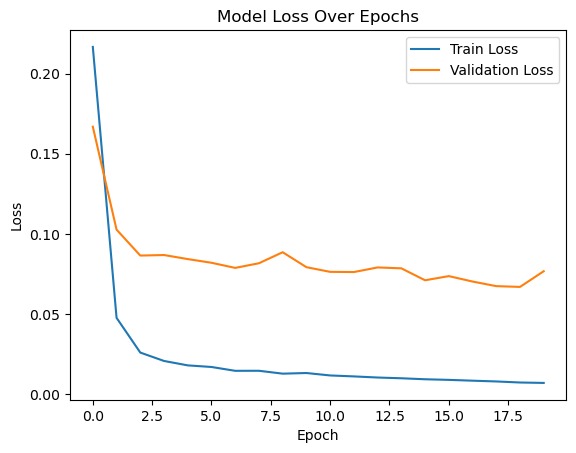

In [179]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

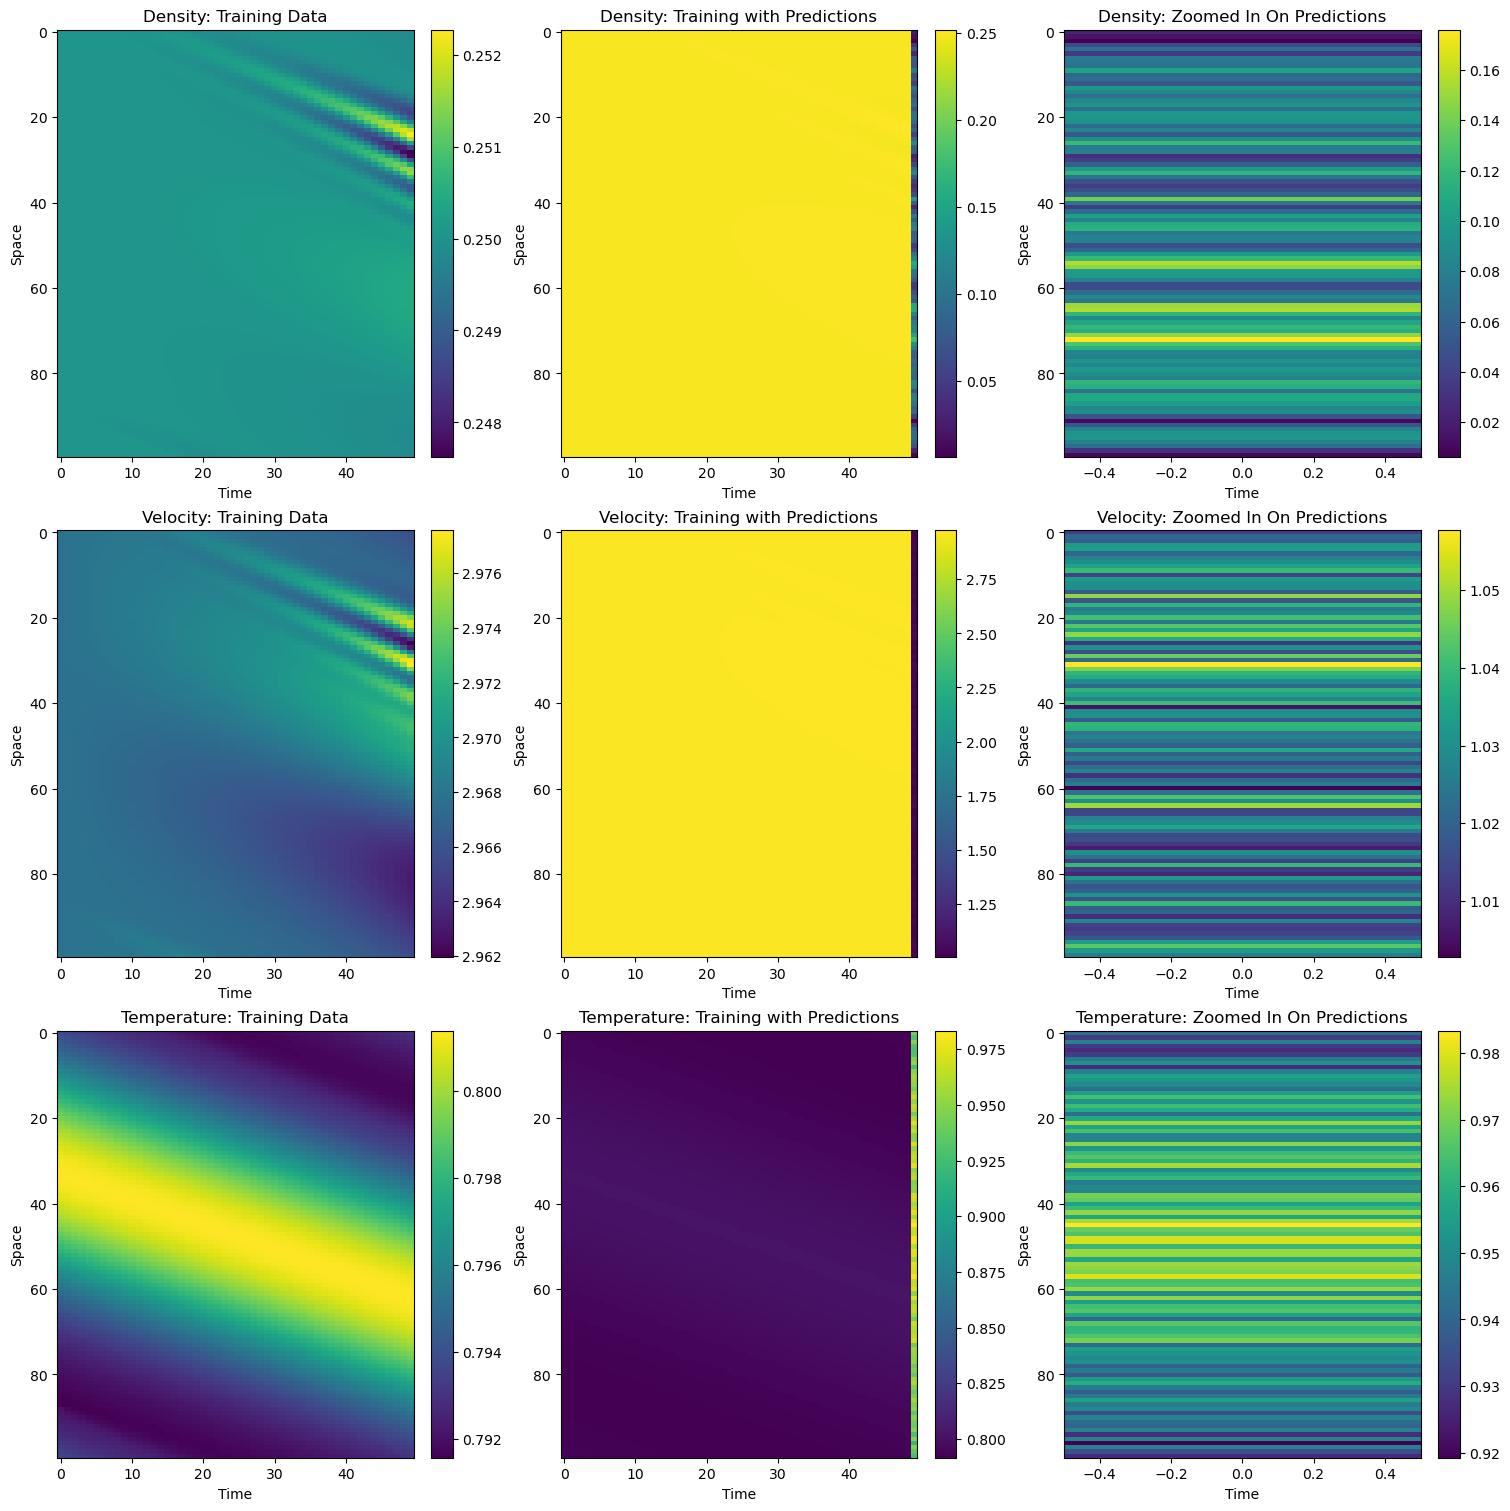

In [181]:
# Visualization
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), constrained_layout=True)
fields = ['Density', 'Velocity', 'Temperature']
instance_idx = 123

for i, field in enumerate(fields):
    # Plot actual data
    ax = axes[i, 0]
    cax = ax.imshow(original_data[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training Data')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot data with predictions
    ax = axes[i, 1]
    cax = ax.imshow(data_with_predictions[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training with Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot only predicted data
    ax = axes[i, 2]
    cax = ax.imshow(data_with_predictions[instance_idx, i, num_train_snapshots:, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Zoomed In On Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

plt.show()

# A very hard lesson learned in: A model is only as good as its data. Don't use data with instabilities

### Now that the ML works... finally

Todo:
I noticed overfitting -> implement earlystopping and a learning rate scheduler
Use Hyperparameter tuning -> to reduce model complexity if possible or increase it if possible
Get New Data!! -> Run more higher fidelity simulations. Use tighter constraints on what simulations are considered acceptable before being considered a valid run
Add additional forecasting through one step ahead

In [191]:
import os
from generate_simulation_data import run_simulation_with_dynamic_conditions

# Simulation parameters
num_samples = 1000
grid_size = 100
num_snapshots = 100
num_steps = 1000
L = 10
dx = L / grid_size
dt = 0.001

# Generate data
data, IC_types_train, IC_params_train, IC_equilibria_train, IC_pertubration_amplitudes_train = run_simulation_with_dynamic_conditions(num_samples, grid_size, num_snapshots, num_steps, L, dx, dt)

# Create Paths to Files
base_directory = "/Users/chrisgerlach/Programming/1DNumericalPDE/MSU Extension/OOP/HPCC/Run Information"
if not os.path.exists(base_directory):
    os.makedirs(base_directory)

simulation_data_path = os.path.join(base_directory,'simulation_data.npz')

# Save Data
np.savez(simulation_data_path, data=data)


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_31 (TimeDi  (None, 10, 3, 100, 32)   320       
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 10, 1, 50, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 10, 1600)         0         
 stributed)                                                      
                                                                 
 lstm_43 (LSTM)              (None, 10, 128)           885248    
                                                                 
 lstm_44 (LSTM)              (None, 64)                49408     
                                                     

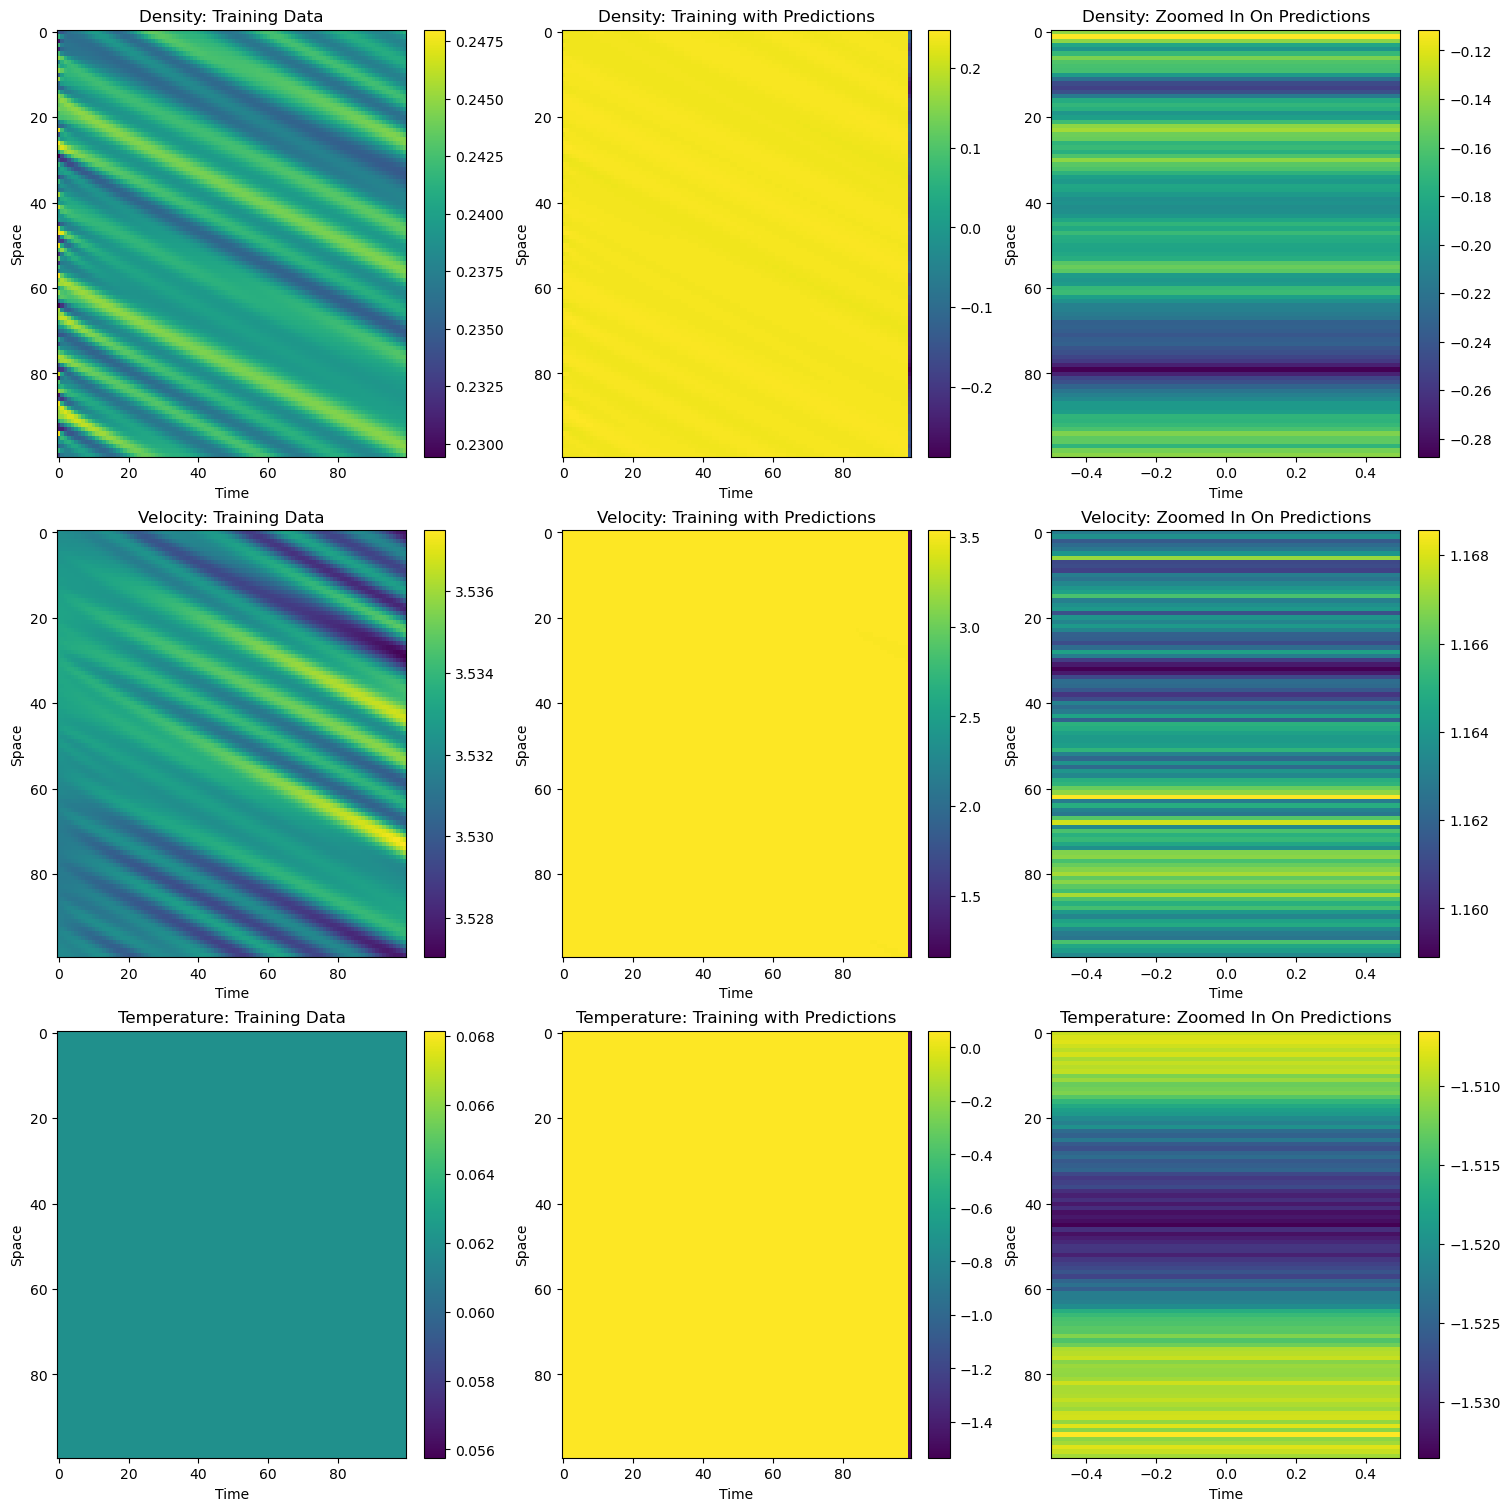

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split

# Load and preprocess the data
original_data = np.load('Run Information/simulation_data.npz')['data']
num_instances, num_fields, num_snapshots, num_points = original_data.shape
num_predicted_snapshots = 1
num_train_snapshots = num_snapshots - num_predicted_snapshots

# Transpose the data to format suitable for CNN and LSTM processing
input_data = np.transpose(original_data, (0, 2, 1, 3))
train_data = input_data[:, :num_train_snapshots, :, :]
target_data = input_data[:, num_train_snapshots:, :, :]

# Normalize the data
mean = np.mean(train_data, axis=(0, 1, 3), keepdims=True)
std = np.std(train_data, axis=(0, 1, 3), keepdims=True)
train_data_normalized = (train_data - mean) / std
target_data_normalized = (target_data - mean) / std

# Function to create training and testing datasets
def create_dataset(dataset, past_steps, num_predicted_snapshots, is_train=True):
    num_instances, num_snapshots, num_fields, num_points = dataset.shape
    num_features = num_fields * num_points
    dataX, dataY = [], []

    if is_train:
        for instance in range(num_instances):
            for start in range(num_snapshots - past_steps - num_predicted_snapshots + 1):
                end = start + past_steps
                seq_x = dataset[instance, start:end, :, :].reshape(past_steps, num_fields, num_points, 1)
                seq_y = dataset[instance, end:end + num_predicted_snapshots, :, :].reshape(num_predicted_snapshots, num_features)
                dataX.append(seq_x)
                dataY.append(seq_y)
    else:
        for instance in range(num_instances):
            # Ensure there are enough snapshots to form a sequence for test data
            if num_snapshots >= past_steps:
                seq_x = dataset[instance, -past_steps:, :, :].reshape(1, past_steps, num_fields, num_points, 1)
                seq_y = target_data[instance, 0, :, :].flatten().reshape(1, num_features)
                dataX.append(seq_x)
                dataY.append(seq_y)

    return np.array(dataX).reshape(-1, past_steps, num_fields, num_points, 1), np.array(dataY).reshape(-1, num_features)

past_steps = 10
trainX, trainY = create_dataset(train_data_normalized, past_steps, num_predicted_snapshots, is_train=True)
testX, testY = create_dataset(train_data_normalized, past_steps, num_predicted_snapshots, is_train=False)

# Setting up the model
model = Sequential([
    TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'), input_shape=(past_steps, num_fields, num_points, 1)),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(num_fields * num_points)
])

# Compiling the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model.summary()

# Adding EarlyStopping and LearningRateScheduler to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with callbacks
history = model.fit(trainX, trainY, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Model evaluation
test_loss, test_mae = model.evaluate(testX, testY)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

# Generate predictions for the test dataset
test_predictions = model.predict(testX)
print(test_predictions.shape)

# Reshape predictions to match original data shape
test_predictions_reshaped = test_predictions.reshape(num_instances, num_fields, num_predicted_snapshots, num_points)

# Concatenating the training data with the predictions
data_with_predictions = np.concatenate([original_data[:, :, :num_train_snapshots, :], test_predictions_reshaped], axis=2)

# Visualization
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), constrained_layout=True)
fields = ['Density', 'Velocity', 'Temperature']
instance_idx = 123

for i, field in enumerate(fields):
    # Plot actual data
    ax = axes[i, 0]
    cax = ax.imshow(original_data[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training Data')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot data with predictions
    ax = axes[i, 1]
    cax = ax.imshow(data_with_predictions[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training with Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot only predicted data
    ax = axes[i, 2]
    cax = ax.imshow(data_with_predictions[instance_idx, i, num_train_snapshots:, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Zoomed In On Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

plt.show()

# The ranges of the predictions are physically inaccurate. 
## Thus, I will enforce the output training data to be in the correct ranges:

Density: [0, 1]

Temperature: >= 0


Additionally, the ranges on the end predictions are too large -> Add regularization.

L1 Regularization on the LSTM to focus on feature extraction from the CNNs
L2 Regularization on the Dense layers to reduce unneccessarily large devations in predictions

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 20, 3, 100,  0           []                               
                                 1)]                                                              
                                                                                                  
 time_distributed_43 (TimeDistr  (None, 20, 3, 100,   320        ['input_4[0][0]']                
 ibuted)                        32)                                                               
                                                                                                  
 time_distributed_44 (TimeDistr  (None, 20, 1, 50, 3  0          ['time_distributed_43[0][0]']    
 ibuted)                        2)                                                          

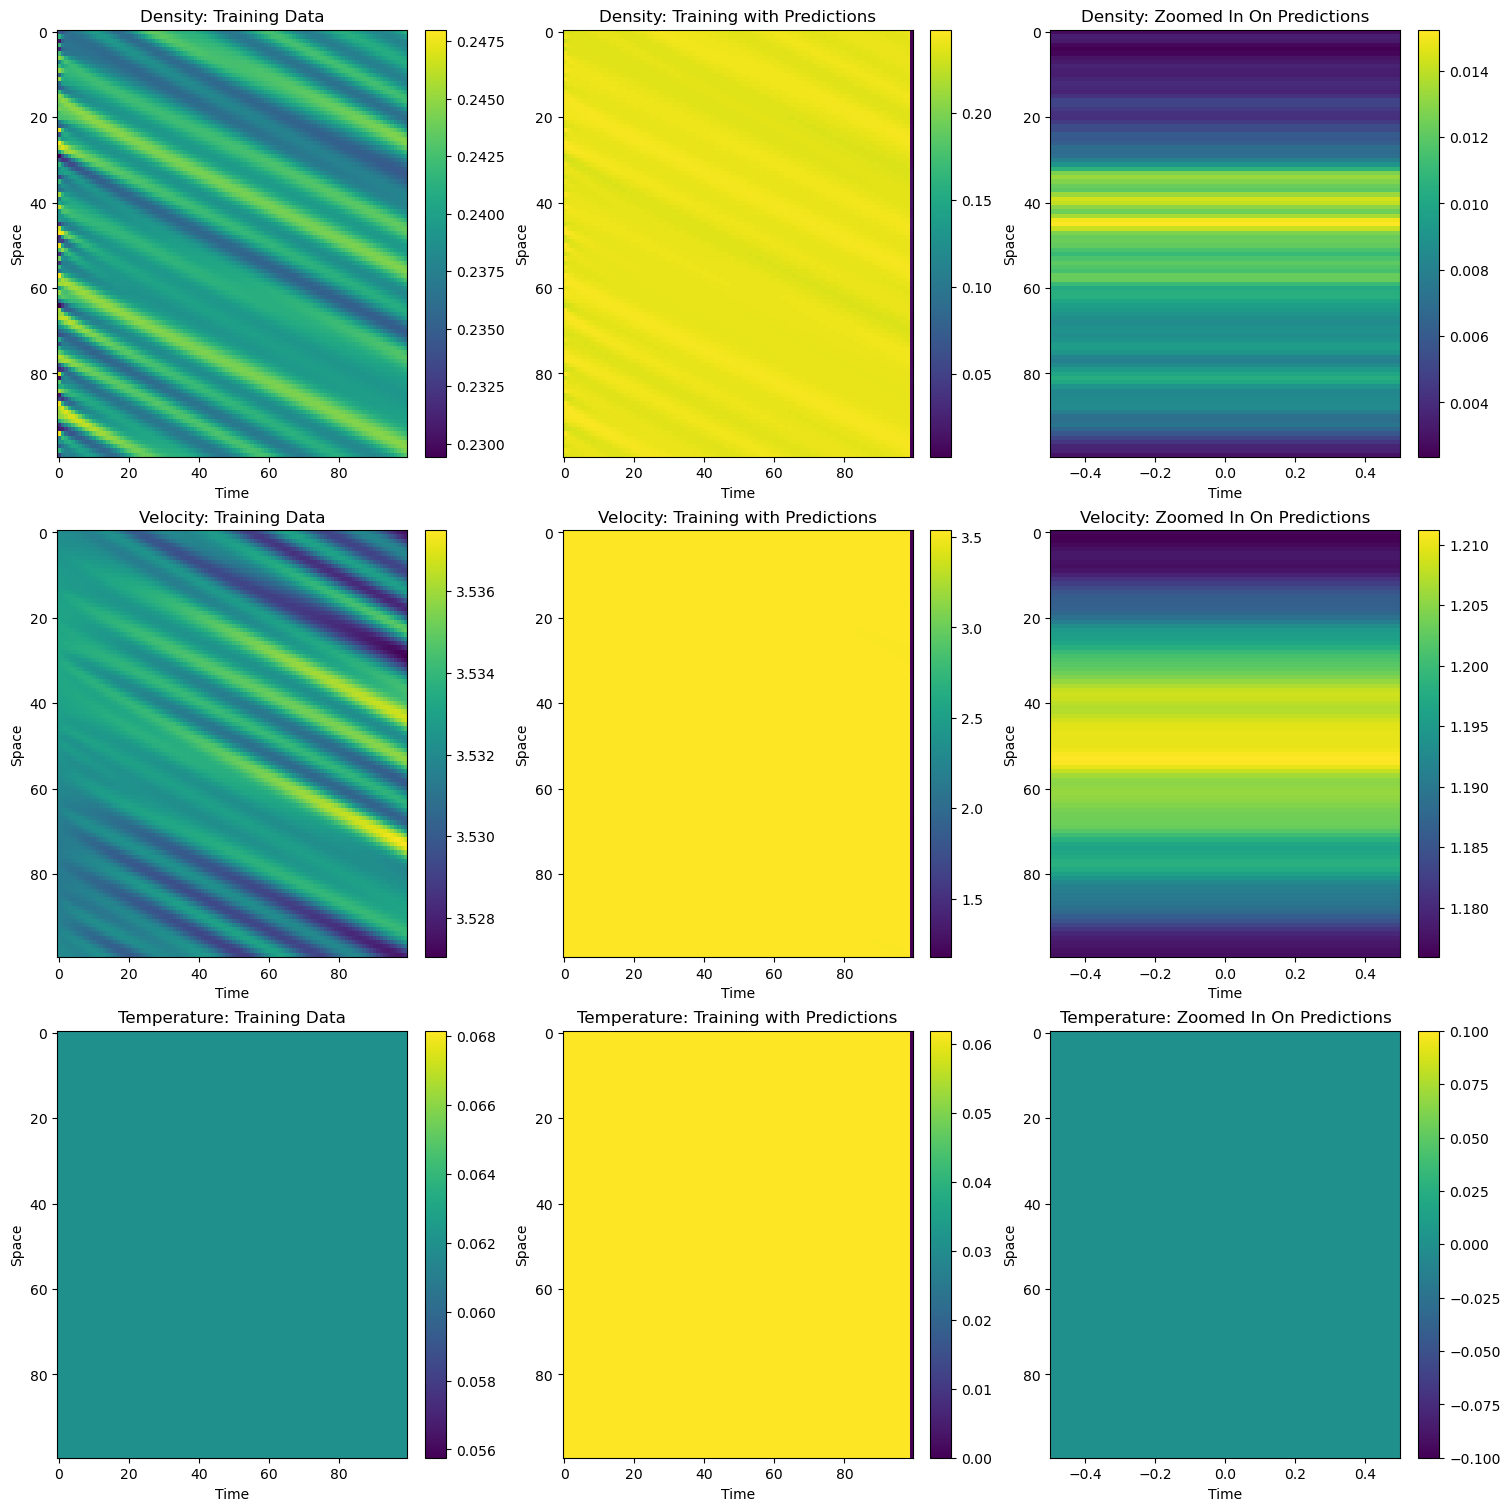

In [204]:
####################################
### Physics Informed Constraints ###
####################################

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.regularizers import l2, l1

# Load and preprocess the data
original_data = np.load('Run Information/simulation_data.npz')['data']
num_instances, num_fields, num_snapshots, num_points = original_data.shape
past_steps = 20  # Number of time steps to consider for the past
num_predicted_snapshots = 1  # Number of time steps for the modelto predict
num_train_snapshots = num_snapshots - num_predicted_snapshots

# Transpose the data to format suitable for CNN and LSTM processing
input_data = np.transpose(original_data, (0, 2, 1, 3))
train_data = input_data[:, :num_train_snapshots, :, :]
target_data = input_data[:, num_train_snapshots:, :, :]

# Normalize the data
mean = np.mean(train_data, axis=(0, 1, 3), keepdims=True)
std = np.std(train_data, axis=(0, 1, 3), keepdims=True)
train_data_normalized = (train_data - mean) / std
target_data_normalized = (target_data - mean) / std

# Function to create training and testing datasets
def create_dataset(dataset, past_steps, num_predicted_snapshots, is_train=True):
    num_instances, num_snapshots, num_fields, num_points = dataset.shape
    num_features = num_fields * num_points
    dataX, dataY = [], []

    if is_train:
        for instance in range(num_instances):
            for start in range(num_snapshots - past_steps - num_predicted_snapshots + 1):
                end = start + past_steps
                seq_x = dataset[instance, start:end, :, :].reshape(past_steps, num_fields, num_points, 1)
                seq_y = dataset[instance, end:end + num_predicted_snapshots, :, :].reshape(num_predicted_snapshots, num_features)
                dataX.append(seq_x)
                dataY.append(seq_y)
    else:
        for instance in range(num_instances):
            # Ensure there are enough snapshots to form a sequence for test data
            if num_snapshots >= past_steps:
                seq_x = dataset[instance, -past_steps:, :, :].reshape(1, past_steps, num_fields, num_points, 1)
                seq_y = target_data[instance, 0, :, :].flatten().reshape(1, num_features)
                dataX.append(seq_x)
                dataY.append(seq_y)

    # Separate output fields for separate physics constraints
    return np.array(dataX).reshape(-1, past_steps, num_fields, num_points, 1), np.array(dataY).reshape(-1, num_points, num_fields)

trainX, trainY = create_dataset(train_data_normalized, past_steps, num_predicted_snapshots, is_train=True)
testX, testY = create_dataset(train_data_normalized, past_steps, num_predicted_snapshots, is_train=False)

reg_factor = 0.01

input_layer = Input(shape=(past_steps, num_fields, num_points, 1))

# Convolutional and LSTM layers
x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))(input_layer)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(128, return_sequences=True, kernel_regularizer=l1(reg_factor))(x)
x = LSTM(64, kernel_regularizer=l1(reg_factor))(x)

# Separate outputs for each field with specific activation functions
output_density = Dense(num_points, activation='sigmoid', kernel_regularizer=l2(reg_factor))(x)  # Density between 0 and 1
output_velocity = Dense(num_points, kernel_regularizer=l2(reg_factor))(x)  # No specific constraints needed here
output_temperature = Dense(num_points, activation='relu', kernel_regularizer=l2(reg_factor))(x)  # Temperature >= 0

# Combine outputs into a single tensor assuming the same order as in trainY_reshaped
outputs = tf.keras.layers.Concatenate(axis=-1)([output_density, output_velocity, output_temperature])
outputs = Reshape((num_points, num_fields))(outputs)  # Reshape to match the new trainY shape

model = Model(inputs=input_layer, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

# Compiling the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model.summary()

# Adding EarlyStopping and LearningRateScheduler to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with callbacks
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Model evaluation
test_loss, test_mae = model.evaluate(testX, testY)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

# Generate predictions for the test dataset
test_predictions = model.predict(testX)
print(test_predictions.shape)

# Reshape predictions to match original data shape
test_predictions_reshaped = test_predictions.reshape(num_instances, num_fields, num_predicted_snapshots, num_points)

# Concatenating the training data with the predictions
data_with_predictions = np.concatenate([original_data[:, :, :num_train_snapshots, :], test_predictions_reshaped], axis=2)

# Visualization
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), constrained_layout=True)
fields = ['Density', 'Velocity', 'Temperature']
instance_idx = 123

for i, field in enumerate(fields):
    # Plot actual data
    ax = axes[i, 0]
    cax = ax.imshow(original_data[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training Data')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot data with predictions
    ax = axes[i, 1]
    cax = ax.imshow(data_with_predictions[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training with Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot only predicted data
    ax = axes[i, 2]
    cax = ax.imshow(data_with_predictions[instance_idx, i, num_train_snapshots:, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Zoomed In On Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

plt.show()

### Now time to apply hyperparameter tuning

In [211]:
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, TimeDistributed, Reshape
from tensorflow.keras.regularizers import l1
from kerastuner.tuners import RandomSearch, BayesianOptimization, Hyperband

# Method for defining the ranges for the hyperparameters
def build_model(hp):
    input_layer = Input(shape=(past_steps, num_fields, num_points, 1))
    
    x = TimeDistributed(Conv2D(
            filters=hp.Int('conv_filters', 16, 64, step=16),
            kernel_size=(3, 3), 
            activation='relu', 
            padding='same',
            kernel_regularizer=l2(hp.Float('conv_l2', 1e-4, 1e-2, sampling='log'))  # L2 regularization for Conv2D layers
        ))(input_layer)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)
    
    x = LSTM(
            hp.Int('lstm_units_1', 64, 256, step=64),
            return_sequences=True,
            kernel_regularizer=l2(hp.Float('lstm_l2', 1e-4, 1e-2, sampling='log'))  # L2 regularization for LSTM layers
        )(x)
    x = LSTM(
            hp.Int('lstm_units_2', 32, 128, step=32),
            kernel_regularizer=l2(hp.Float('lstm_l2', 1e-4, 1e-2, sampling='log'))
        )(x)
    
    output_density = Dense(
            num_points, 
            activation='sigmoid', 
            kernel_regularizer=l2(hp.Float('dense_density_l2', 1e-4, 1e-2, sampling='log'))
        )(x)
    output_velocity = Dense(
            num_points, 
            kernel_regularizer=l2(hp.Float('dense_velocity_l2', 1e-4, 1e-2, sampling='log'))
        )(x)
    output_temperature = Dense(
            num_points, 
            activation='relu', 
            kernel_regularizer=l2(hp.Float('dense_temperature_l2', 1e-4, 1e-2, sampling='log'))
        )(x)
    
    outputs = tf.keras.layers.Concatenate(axis=-1)([output_density, output_velocity, output_temperature])
    outputs = Reshape((num_points, num_fields))(outputs)
    
    model = Model(inputs=input_layer, outputs=outputs)
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model


# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    min_delta=0.0025, 
    restore_best_weights=True
)

# LearningRateScheduler to adjust the learning rate over epochs
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Configure the tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='model_tuning',
    project_name='cnn_lstm_tuning'
)

# Start the search
tuner.search(
    trainX,
    trainY,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Get the optimal model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

# Summary of the best model
best_model.summary()
print("Best hyperparameters:", best_hyperparameters.values)

Trial 20 Complete [00h 09m 12s]
val_loss: 0.5872113704681396

Best val_loss So Far: 0.49919572472572327
Total elapsed time: 02h 55m 20s
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 3, 100,  0           []                               
                                 1)]                                                              
                                                                                                  
 time_distributed (TimeDistribu  (None, 20, 3, 100,   320        ['input_1[0][0]']                
 ted)                           32)                                                               
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 20, 1, 50, 3  0  

AttributeError: 'BayesianOptimizationOracle' object has no attribute 'get_trials'

# Best hyperparameters:

Best hyperparameters: {
    'conv_filters': 32, 
    'conv_l2': 0.0013868016325519167, 
    'lstm_units_1': 128, 
    'lstm_l2': 0.0002140821791690464, 
    'lstm_units_2': 32, 
    'dense_density_l2': 0.0002472161416221352, 
    'dense_velocity_l2': 0.00010255183073925845, 
    'dense_temperature_l2': 0.00022282577593816228, 
    'learning_rate': 0.0005784835288928163
}

Approximate -> Best hyperparameters: {
    'conv_filters': 32, 
    'conv_l2': 0.001, 
    'lstm_units_1': 128, 
    'lstm_l2': 0.0002, 
    'lstm_units_2': 32, 
    'dense_density_l2': 0.00025, 
    'dense_velocity_l2': 0.0001, 
    'dense_temperature_l2': 0.0002, 
    'learning_rate': 0.0005
}

In [217]:
# Access the trials directly if possible
trials = tuner.oracle.trials

# Create lists to store data
hyperparameters_list = []
trial_ids = []
scores = []
val_losses = []
val_maes = []

# Iterate over each trial
for trial_id, trial in trials.items():
    hyperparams = trial.hyperparameters.values
    score = trial.score
    val_loss = trial.metrics.get_best_value('val_loss')
    val_mae = trial.metrics.get_best_value('val_mae')

    # Append each trial's results to the lists
    trial_ids.append(trial_id)
    hyperparameters_list.append(hyperparams)
    scores.append(score)
    val_losses.append(val_loss)
    val_maes.append(val_mae)

# Create a DataFrame from the lists
df_trials = pd.DataFrame(hyperparameters_list)
df_trials['trial_id'] = trial_ids
df_trials['score'] = scores
df_trials['val_loss'] = val_losses
df_trials['val_mae'] = val_maes

# Print the DataFrame
print(df_trials)

    conv_filters   conv_l2  lstm_units_1   lstm_l2  lstm_units_2  \
0             48  0.000340           256  0.006296           128   
1             32  0.002341           128  0.001699            32   
2             48  0.006903           192  0.003020            32   
3             64  0.000199           192  0.004424            32   
4             48  0.000149           128  0.001605            32   
5             16  0.000325            64  0.003482           128   
6             32  0.000448           256  0.006025            32   
7             32  0.001387           128  0.000214            32   
8             16  0.001097           256  0.007346            32   
9             16  0.002449            64  0.006759            64   
10            48  0.000891           192  0.001623            64   
11            48  0.000105            64  0.006122            96   
12            16  0.002596           256  0.000316            32   
13            48  0.000161            64  0.0001

In [218]:
# Summarize the results
tuner.results_summary()

Results summary
Results in model_tuning/cnn_lstm_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
conv_filters: 32
conv_l2: 0.0013868016325519167
lstm_units_1: 128
lstm_l2: 0.0002140821791690464
lstm_units_2: 32
dense_density_l2: 0.0002472161416221352
dense_velocity_l2: 0.00010255183073925845
dense_temperature_l2: 0.00022282577593816228
learning_rate: 0.0005784835288928163
Score: 0.49919572472572327

Trial 00 summary
Hyperparameters:
conv_filters: 48
conv_l2: 0.0003398829436430771
lstm_units_1: 256
lstm_l2: 0.00629636851753465
lstm_units_2: 128
dense_density_l2: 0.0027673623449558913
dense_velocity_l2: 0.0017109580932539808
dense_temperature_l2: 0.000301253516865534
learning_rate: 0.0007249428101859649
Score: 0.5556216835975647

Trial 17 summary
Hyperparameters:
conv_filters: 32
conv_l2: 0.0023285010665210285
lstm_units_1: 192
lstm_l2: 0.0011945519459253546
lstm_units_2: 64
dense_density_l2: 0.0007150798267677958
dense_velocit

/opt/anaconda3/envs/AML/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/AML/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/AML/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/AML/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

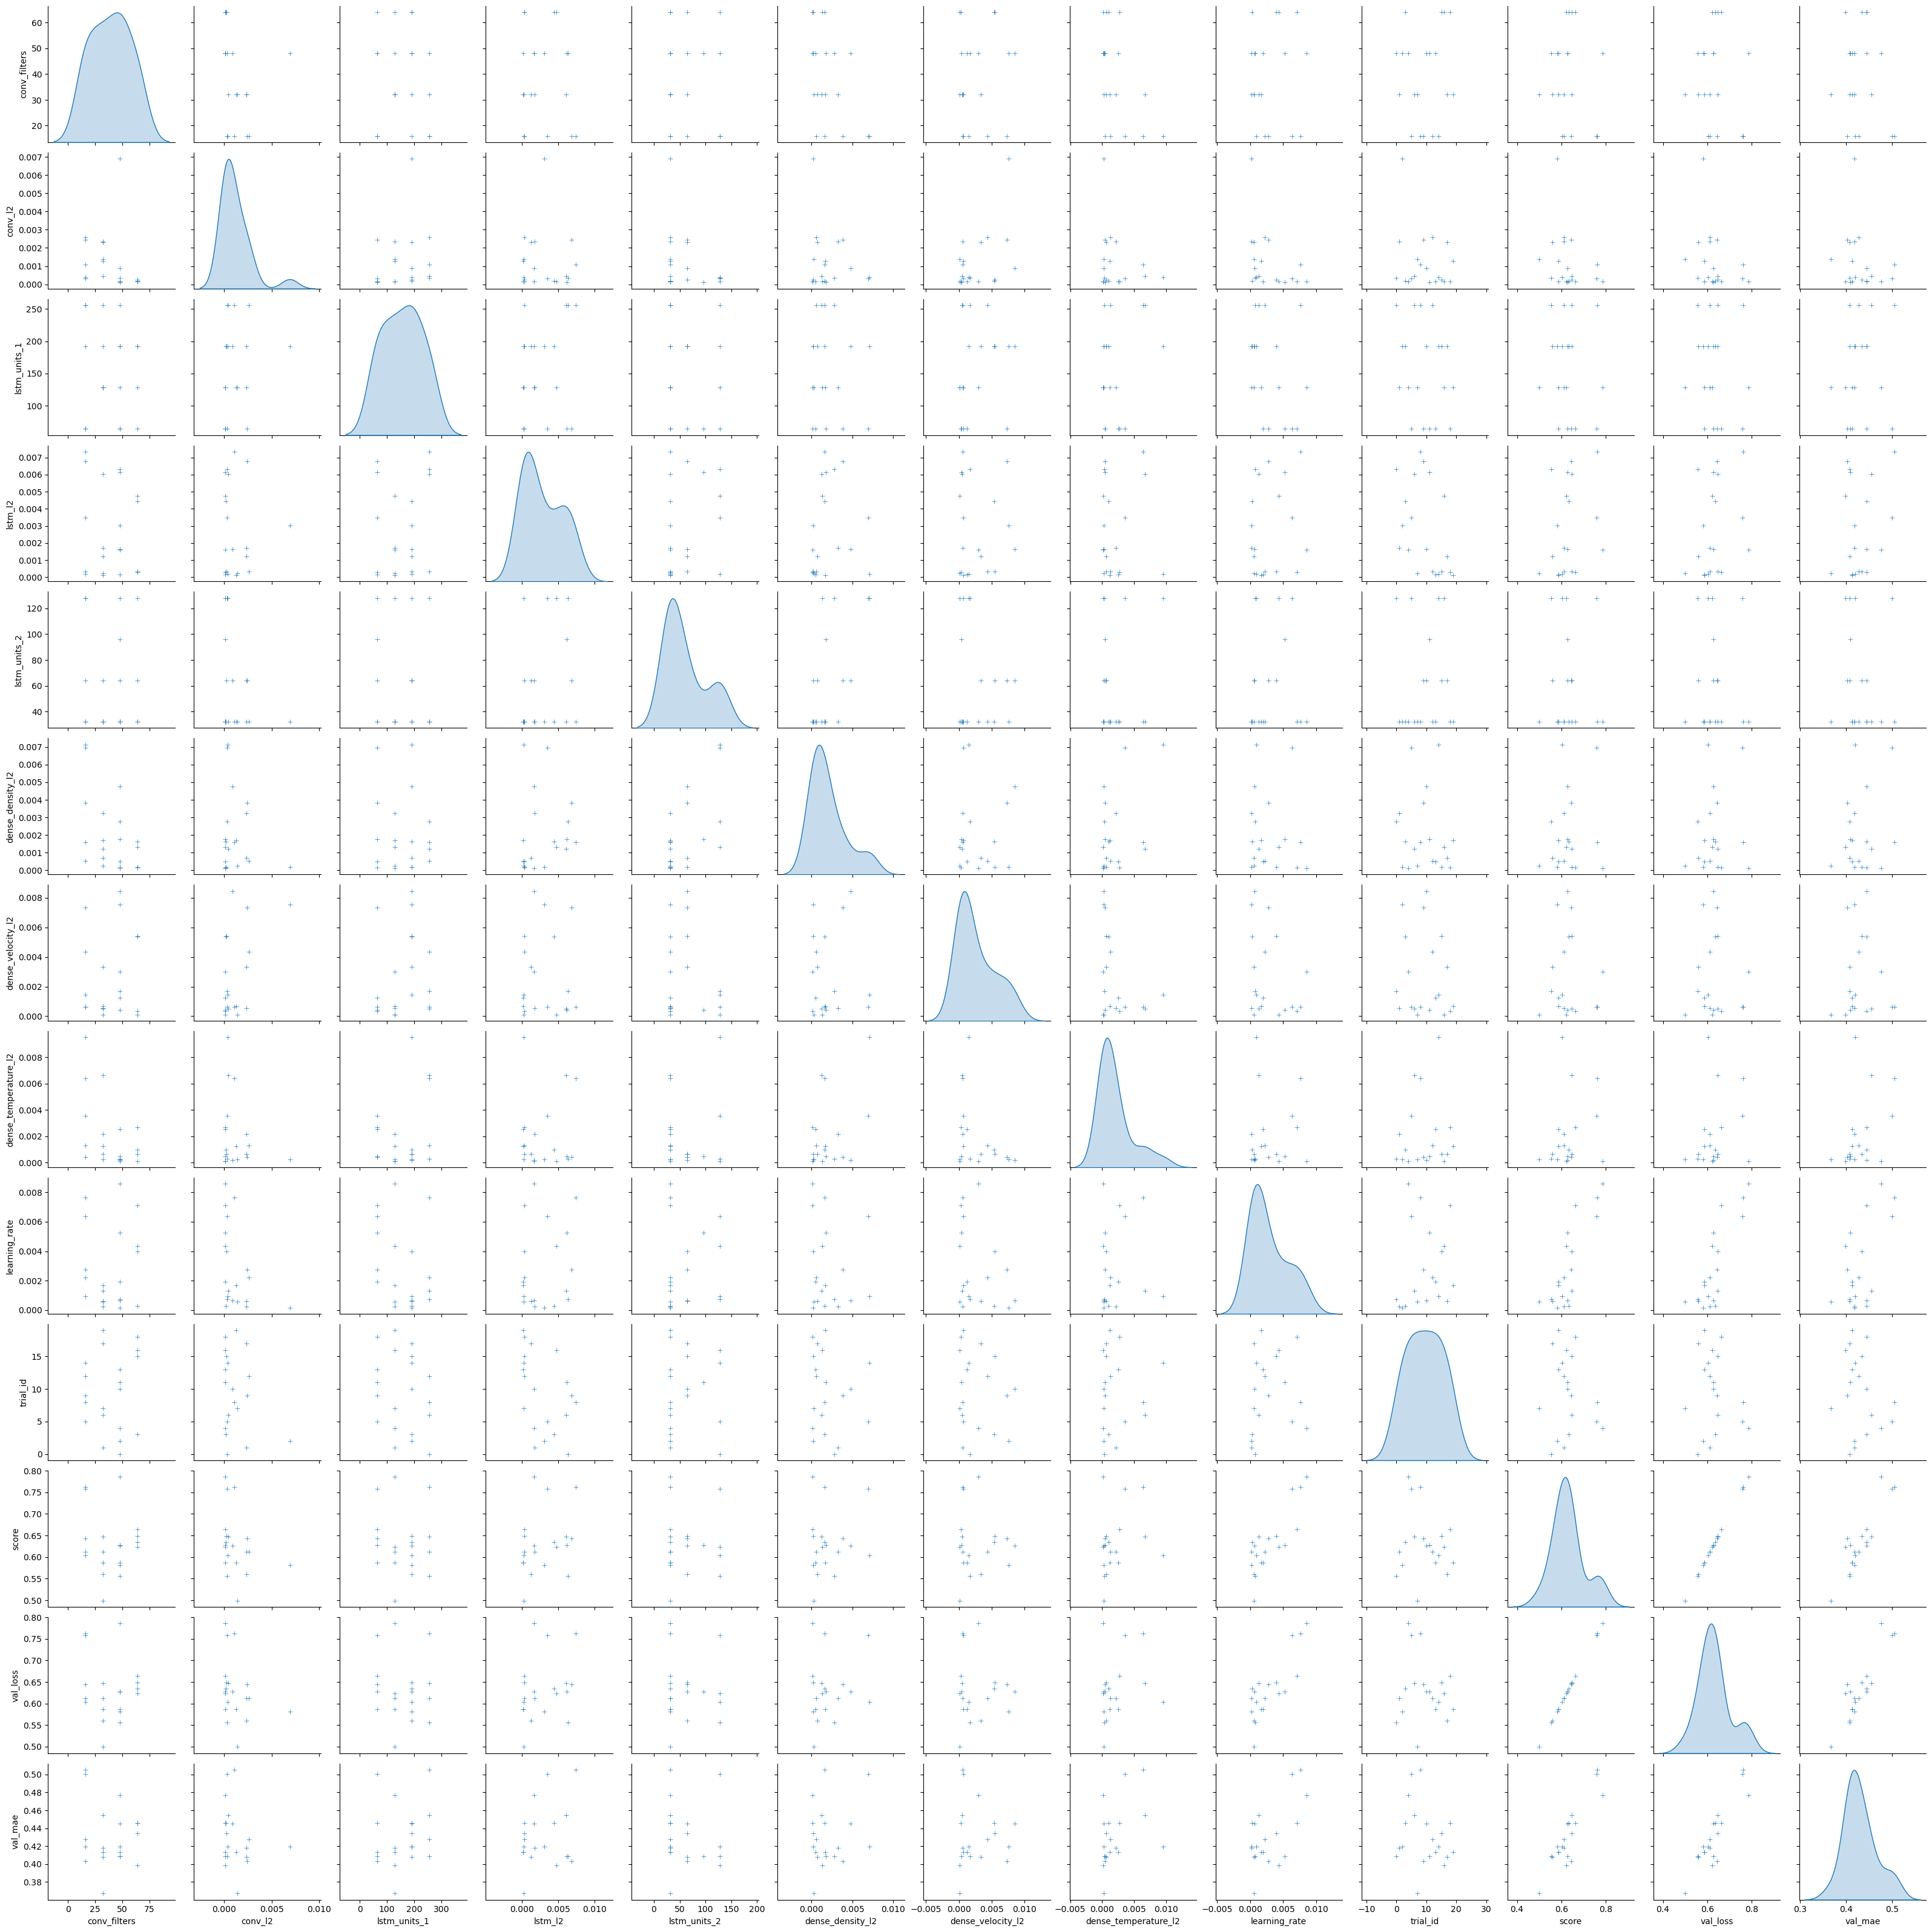

In [220]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pair plot
sns.pairplot(df_trials, kind='scatter', diag_kind='kde', markers='+')
plt.show()


In [221]:
# Calculate correlations
correlation_matrix = df_trials.corr()

# Print the correlation of each hyperparameter with the score
print("Correlations between hyperparameters and the score:")
print(correlation_matrix['score'].sort_values(ascending=False))


Correlations between hyperparameters and the score:
score                   1.000000
val_loss                1.000000
val_mae                 0.894804
learning_rate           0.817746
lstm_l2                 0.288041
dense_temperature_l2    0.260175
dense_density_l2        0.169972
lstm_units_2           -0.001667
dense_velocity_l2      -0.042119
conv_filters           -0.103177
lstm_units_1           -0.103270
trial_id               -0.136574
conv_l2                -0.294610
Name: score, dtype: float64


## As I saw throughout the training, the leearning rate had by far the biggest impact on the model. 

And since the model isn't performing well still within the range of hyperparameters I originally defined, I want to explore a separate hyperparameter space with a lower learning rate.

In [222]:

# Method for defining the ranges for the hyperparameters
def lr_modified_build_model(hp):
    input_layer = Input(shape=(past_steps, num_fields, num_points, 1))
    
    x = TimeDistributed(Conv2D(
            filters=hp.Int('conv_filters', 16, 64, step=16),
            kernel_size=(3, 3), 
            activation='relu', 
            padding='same',
            kernel_regularizer=l2(hp.Float('conv_l2', 1e-4, 1e-2, sampling='log'))  # L2 regularization for Conv2D layers
        ))(input_layer)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)
    
    x = LSTM(
            hp.Int('lstm_units_1', 64, 256, step=64),
            return_sequences=True,
            kernel_regularizer=l2(hp.Float('lstm_l2', 1e-4, 1e-2, sampling='log'))  # L2 regularization for LSTM layers
        )(x)
    x = LSTM(
            hp.Int('lstm_units_2', 32, 128, step=32),
            kernel_regularizer=l2(hp.Float('lstm_l2', 1e-4, 1e-2, sampling='log'))
        )(x)
    
    output_density = Dense(
            num_points, 
            activation='sigmoid', 
            kernel_regularizer=l2(hp.Float('dense_density_l2', 1e-4, 1e-2, sampling='log'))
        )(x)
    output_velocity = Dense(
            num_points, 
            kernel_regularizer=l2(hp.Float('dense_velocity_l2', 1e-4, 1e-2, sampling='log'))
        )(x)
    output_temperature = Dense(
            num_points, 
            activation='relu', 
            kernel_regularizer=l2(hp.Float('dense_temperature_l2', 1e-4, 1e-2, sampling='log'))
        )(x)
    
    outputs = tf.keras.layers.Concatenate(axis=-1)([output_density, output_velocity, output_temperature])
    outputs = Reshape((num_points, num_fields))(outputs)
    
    model = Model(inputs=input_layer, outputs=outputs)
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-7, 1e-4, sampling='log')),
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model


# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    min_delta=0.0025, 
    restore_best_weights=True
)

# LearningRateScheduler to adjust the learning rate over epochs
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Configure the tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20 + 20,
    executions_per_trial=1,
    directory='model_tuning',
    project_name='cnn_lstm_tuning'
)

# Start the search
tuner.search(
    trainX,
    trainY,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


Trial 40 Complete [00h 12m 31s]
val_loss: 0.5035281181335449

Best val_loss So Far: 0.4634927809238434
Total elapsed time: 1d 02h 29m 38s


In [223]:
# Calculate correlations
correlation_matrix = df_trials.corr()

# Print the correlation of each hyperparameter with the score
print("Correlations between hyperparameters and the score:")
print(correlation_matrix['score'].sort_values(ascending=False))


Correlations between hyperparameters and the score:
score                   1.000000
val_loss                1.000000
val_mae                 0.894804
learning_rate           0.817746
lstm_l2                 0.288041
dense_temperature_l2    0.260175
dense_density_l2        0.169972
lstm_units_2           -0.001667
dense_velocity_l2      -0.042119
conv_filters           -0.103177
lstm_units_1           -0.103270
trial_id               -0.136574
conv_l2                -0.294610
Name: score, dtype: float64


In [224]:
# Summary of the best model
best_model.summary()
print("Best hyperparameters:", best_hyperparameters.values)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 3, 100,  0           []                               
                                 1)]                                                              
                                                                                                  
 time_distributed (TimeDistribu  (None, 20, 3, 100,   320        ['input_1[0][0]']                
 ted)                           32)                                                               
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 20, 1, 50, 3  0          ['time_distributed[0][0]']       
 buted)                         2)                                                            

Previous Best hyperparameters: {
    'conv_filters': 32, 
    'conv_l2': 0.001, 
    'lstm_units_1': 128, 
    'lstm_l2': 0.0002, 
    'lstm_units_2': 32, 
    'dense_density_l2': 0.00025, 
    'dense_velocity_l2': 0.0001, 
    'dense_temperature_l2': 0.0002, 
    'learning_rate': 0.0005
}

New Approximate Best hyperparameters: {
    'conv_filters': 32, 
    'conv_l2': 0.001, 
    'lstm_units_1': 128, 
    'lstm_l2': 0.0002, 
    'lstm_units_2': 32, 
    'dense_density_l2': 0.00025, 
    'dense_velocity_l2': 0.0001, 
    'dense_temperature_l2': 0.0002, 
    'learning_rate': 0.0006
}

The learning didn't go as hoped...

Maybe make the model more complex? In order to save time, I won't perform anymore hyperparameter tuning. But will simply compare the more complex model to the previous. Ideally, I would perform another round of hyperparameter tuning:

In [227]:
####################################
### Physics Informed Constraints ###
####################################

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.regularizers import l2, l1

# Load and preprocess the data
original_data = np.load('Run Information/simulation_data.npz')['data']
num_instances, num_fields, num_snapshots, num_points = original_data.shape
past_steps = 20  # Number of time steps to consider for the past
num_predicted_snapshots = 1  # Number of time steps for the modelto predict
num_train_snapshots = num_snapshots - num_predicted_snapshots

# Transpose the data to format suitable for CNN and LSTM processing
input_data = np.transpose(original_data, (0, 2, 1, 3))
train_data = input_data[:, :num_train_snapshots, :, :]
target_data = input_data[:, num_train_snapshots:, :, :]

# Normalize the data
mean = np.mean(train_data, axis=(0, 1, 3), keepdims=True)
std = np.std(train_data, axis=(0, 1, 3), keepdims=True)
train_data_normalized = (train_data - mean) / std
target_data_normalized = (target_data - mean) / std

# Function to create training and testing datasets
def create_dataset(dataset, past_steps, num_predicted_snapshots, is_train=True):
    num_instances, num_snapshots, num_fields, num_points = dataset.shape
    num_features = num_fields * num_points
    dataX, dataY = [], []

    if is_train:
        for instance in range(num_instances):
            for start in range(num_snapshots - past_steps - num_predicted_snapshots + 1):
                end = start + past_steps
                seq_x = dataset[instance, start:end, :, :].reshape(past_steps, num_fields, num_points, 1)
                seq_y = dataset[instance, end:end + num_predicted_snapshots, :, :].reshape(num_predicted_snapshots, num_features)
                dataX.append(seq_x)
                dataY.append(seq_y)
    else:
        for instance in range(num_instances):
            # Ensure there are enough snapshots to form a sequence for test data
            if num_snapshots >= past_steps:
                seq_x = dataset[instance, -past_steps:, :, :].reshape(1, past_steps, num_fields, num_points, 1)
                seq_y = target_data[instance, 0, :, :].flatten().reshape(1, num_features)
                dataX.append(seq_x)
                dataY.append(seq_y)

    # Separate output fields for separate physics constraints
    return np.array(dataX).reshape(-1, past_steps, num_fields, num_points, 1), np.array(dataY).reshape(-1, num_points, num_fields)

trainX, trainY = create_dataset(train_data_normalized, past_steps, num_predicted_snapshots, is_train=True)
testX, testY = create_dataset(train_data_normalized, past_steps, num_predicted_snapshots, is_train=False)

reg_factor = 0.01

input_layer = Input(shape=(past_steps, num_fields, num_points, 1))

# Convolutional and LSTM layers
x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))(input_layer)
x = TimeDistributed(Flatten())(x)
x = LSTM(128, return_sequences=True, kernel_regularizer=l1(reg_factor))(x)
x = LSTM(64, kernel_regularizer=l1(reg_factor))(x)

# Separate outputs for each field with specific activation functions
output_density = Dense(num_points, activation='sigmoid', kernel_regularizer=l2(reg_factor))(x)  # Density between 0 and 1
output_velocity = Dense(num_points, kernel_regularizer=l2(reg_factor))(x)  # No specific constraints needed here
output_temperature = Dense(num_points, activation='relu', kernel_regularizer=l2(reg_factor))(x)  # Temperature >= 0

# Combine outputs into a single tensor assuming the same order as in trainY_reshaped
outputs = tf.keras.layers.Concatenate(axis=-1)([output_density, output_velocity, output_temperature])
outputs = Reshape((num_points, num_fields))(outputs)  # Reshape to match the new trainY shape

model = Model(inputs=input_layer, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

# Compiling the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model.summary()

# Adding EarlyStopping and LearningRateScheduler to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with callbacks
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Model evaluation
test_loss, test_mae = model.evaluate(testX, testY)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

# Generate predictions for the test dataset
test_predictions = model.predict(testX)
print(test_predictions.shape)

# Reshape predictions to match original data shape
test_predictions_reshaped = test_predictions.reshape(num_instances, num_fields, num_predicted_snapshots, num_points)

# Concatenating the training data with the predictions
data_with_predictions = np.concatenate([original_data[:, :, :num_train_snapshots, :], test_predictions_reshaped], axis=2)

# Visualization
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), constrained_layout=True)
fields = ['Density', 'Velocity', 'Temperature']
instance_idx = 123

for i, field in enumerate(fields):
    # Plot actual data
    ax = axes[i, 0]
    cax = ax.imshow(original_data[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training Data')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot data with predictions
    ax = axes[i, 1]
    cax = ax.imshow(data_with_predictions[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training with Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot only predicted data
    ax = axes[i, 2]
    cax = ax.imshow(data_with_predictions[instance_idx, i, num_train_snapshots:, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Zoomed In On Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

plt.show()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 20, 3, 100,  0           []                               
                                 1)]                                                              
                                                                                                  
 time_distributed_12 (TimeDistr  (None, 20, 3, 100,   320        ['input_4[0][0]']                
 ibuted)                        32)                                                               
                                                                                                  
 time_distributed_13 (TimeDistr  (None, 20, 9600)    0           ['time_distributed_12[0][0]']    
 ibuted)                                                                                    

KeyboardInterrupt: 

## The above didn't work (Check Loss). Lets try the additional CNN layer now.

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 20, 3, 100,  0           []                               
                                 1)]                                                              
                                                                                                  
 time_distributed_14 (TimeDistr  (None, 20, 3, 100,   320        ['input_5[0][0]']                
 ibuted)                        32)                                                               
                                                                                                  
 time_distributed_15 (TimeDistr  (None, 20, 1, 50, 3  0          ['time_distributed_14[0][0]']    
 ibuted)                        2)                                                          

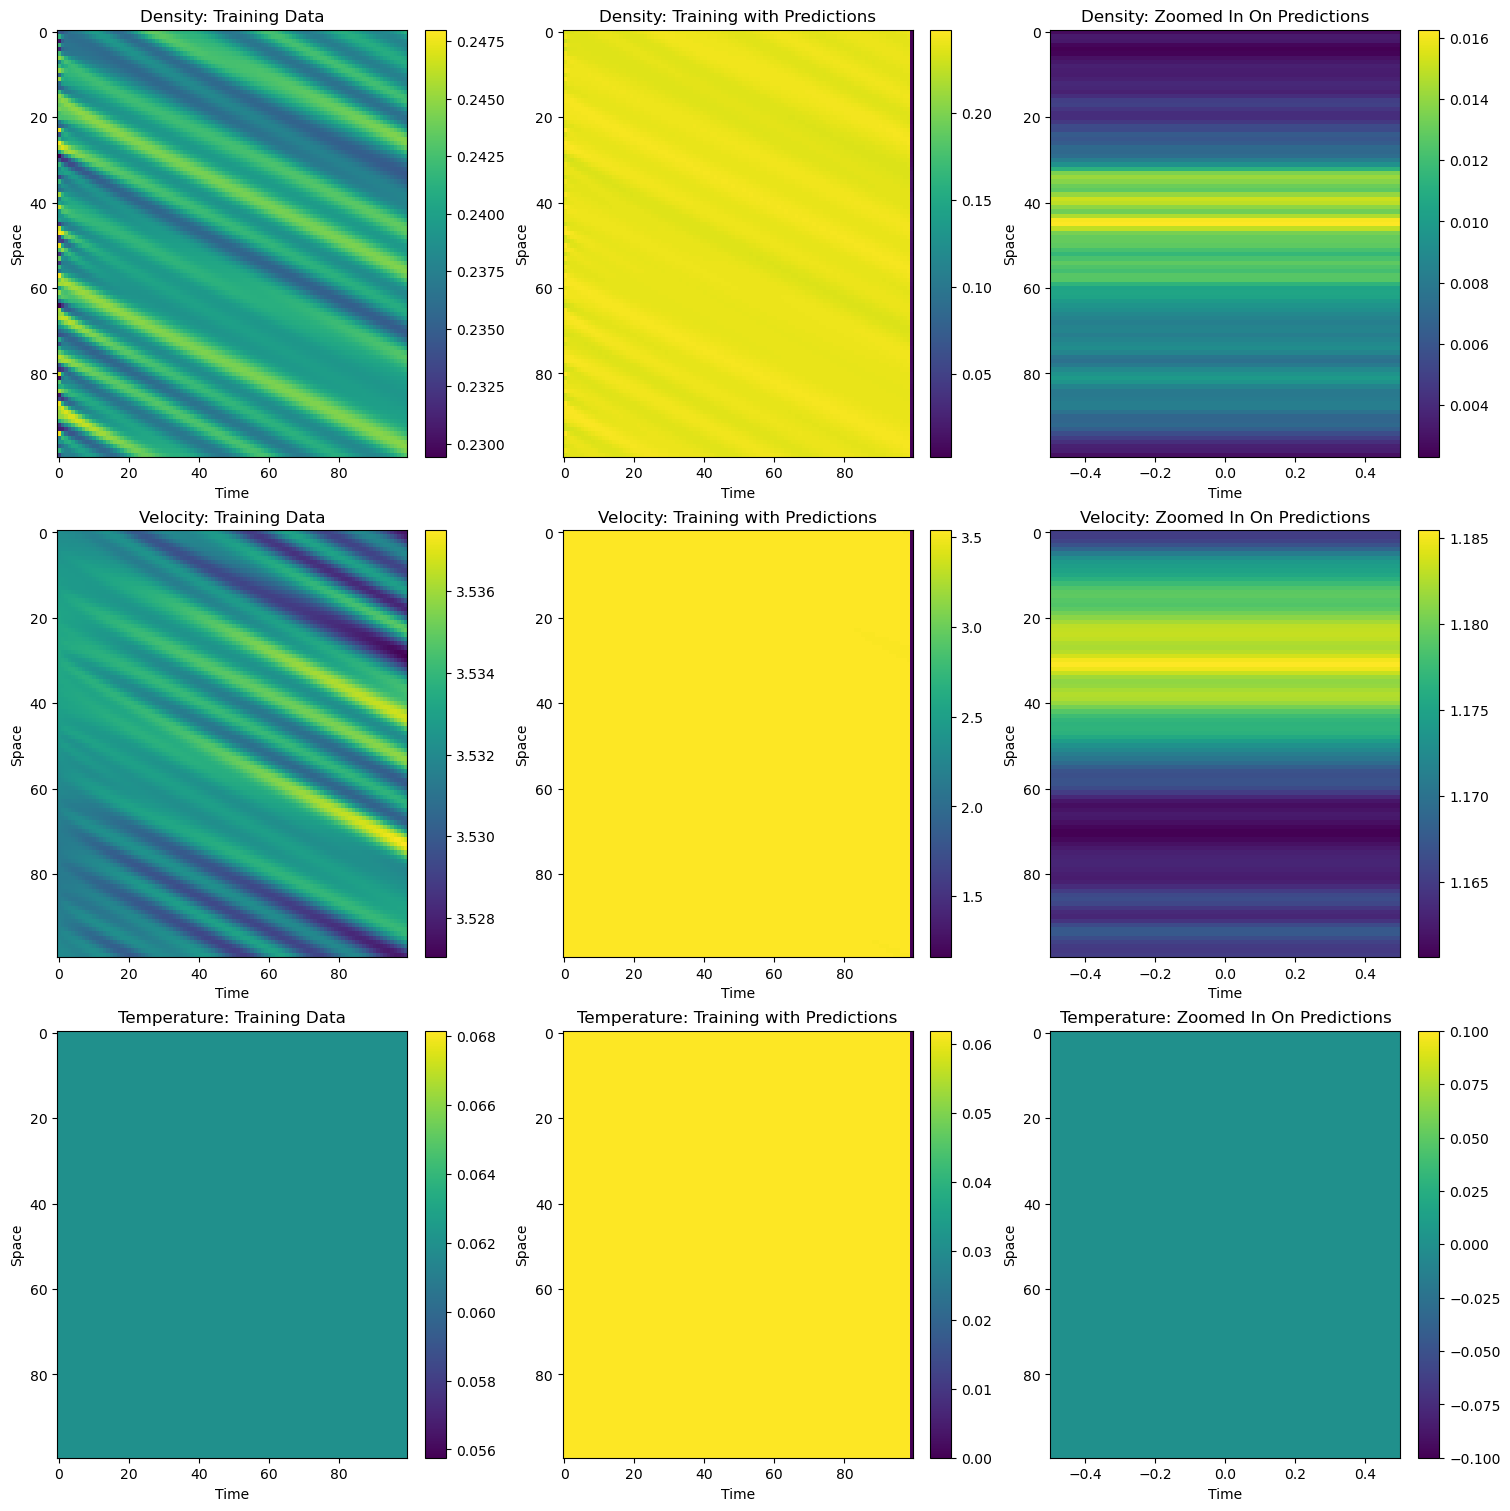

In [228]:
####################################
### Physics Informed Constraints ###
####################################

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.regularizers import l2, l1

# Load and preprocess the data
original_data = np.load('Run Information/simulation_data.npz')['data']
num_instances, num_fields, num_snapshots, num_points = original_data.shape
past_steps = 20  # Number of time steps to consider for the past
num_predicted_snapshots = 1  # Number of time steps for the modelto predict
num_train_snapshots = num_snapshots - num_predicted_snapshots

# Transpose the data to format suitable for CNN and LSTM processing
input_data = np.transpose(original_data, (0, 2, 1, 3))
train_data = input_data[:, :num_train_snapshots, :, :]
target_data = input_data[:, num_train_snapshots:, :, :]

# Normalize the data
mean = np.mean(train_data, axis=(0, 1, 3), keepdims=True)
std = np.std(train_data, axis=(0, 1, 3), keepdims=True)
train_data_normalized = (train_data - mean) / std
target_data_normalized = (target_data - mean) / std

# Function to create training and testing datasets
def create_dataset(dataset, past_steps, num_predicted_snapshots, is_train=True):
    num_instances, num_snapshots, num_fields, num_points = dataset.shape
    num_features = num_fields * num_points
    dataX, dataY = [], []

    if is_train:
        for instance in range(num_instances):
            for start in range(num_snapshots - past_steps - num_predicted_snapshots + 1):
                end = start + past_steps
                seq_x = dataset[instance, start:end, :, :].reshape(past_steps, num_fields, num_points, 1)
                seq_y = dataset[instance, end:end + num_predicted_snapshots, :, :].reshape(num_predicted_snapshots, num_features)
                dataX.append(seq_x)
                dataY.append(seq_y)
    else:
        for instance in range(num_instances):
            # Ensure there are enough snapshots to form a sequence for test data
            if num_snapshots >= past_steps:
                seq_x = dataset[instance, -past_steps:, :, :].reshape(1, past_steps, num_fields, num_points, 1)
                seq_y = target_data[instance, 0, :, :].flatten().reshape(1, num_features)
                dataX.append(seq_x)
                dataY.append(seq_y)

    # Separate output fields for separate physics constraints
    return np.array(dataX).reshape(-1, past_steps, num_fields, num_points, 1), np.array(dataY).reshape(-1, num_points, num_fields)

trainX, trainY = create_dataset(train_data_normalized, past_steps, num_predicted_snapshots, is_train=True)
testX, testY = create_dataset(train_data_normalized, past_steps, num_predicted_snapshots, is_train=False)

reg_factor = 0.01

input_layer = Input(shape=(past_steps, num_fields, num_points, 1))

# Convolutional layer
x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))(input_layer)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)

# Additional Convolutional and Pooling Layer
x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D((1, 2)))(x)  # Adjusted pooling size

x = TimeDistributed(Flatten())(x)

# LSTM layers
x = LSTM(128, return_sequences=True, kernel_regularizer=l1(reg_factor))(x)
x = LSTM(64, kernel_regularizer=l1(reg_factor))(x)

# Separate outputs for each field with specific activation functions
output_density = Dense(num_points, activation='sigmoid', kernel_regularizer=l2(reg_factor))(x)  # Density between 0 and 1
output_velocity = Dense(num_points, kernel_regularizer=l2(reg_factor))(x)  # No specific constraints needed here
output_temperature = Dense(num_points, activation='relu', kernel_regularizer=l2(reg_factor))(x)  # Temperature >= 0

# Combine outputs into a single tensor assuming the same order as in trainY_reshaped
outputs = tf.keras.layers.Concatenate(axis=-1)([output_density, output_velocity, output_temperature])
outputs = Reshape((num_points, num_fields))(outputs)  # Reshape to match the new trainY shape

model = Model(inputs=input_layer, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

# Compiling the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model.summary()

# Adding EarlyStopping and LearningRateScheduler to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with callbacks
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Model evaluation
test_loss, test_mae = model.evaluate(testX, testY)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

# Generate predictions for the test dataset
test_predictions = model.predict(testX)
print(test_predictions.shape)

# Reshape predictions to match original data shape
test_predictions_reshaped = test_predictions.reshape(num_instances, num_fields, num_predicted_snapshots, num_points)

# Concatenating the training data with the predictions
data_with_predictions = np.concatenate([original_data[:, :, :num_train_snapshots, :], test_predictions_reshaped], axis=2)

# Visualization
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), constrained_layout=True)
fields = ['Density', 'Velocity', 'Temperature']
instance_idx = 123

for i, field in enumerate(fields):
    # Plot actual data
    ax = axes[i, 0]
    cax = ax.imshow(original_data[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training Data')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot data with predictions
    ax = axes[i, 1]
    cax = ax.imshow(data_with_predictions[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training with Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot only predicted data
    ax = axes[i, 2]
    cax = ax.imshow(data_with_predictions[instance_idx, i, num_train_snapshots:, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Zoomed In On Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

plt.show()

# Best Model: 1 CNN, 1 MaxPooling, with last hyperparameter tuning

In [269]:
####################################
### Physics Informed Constraints ###
####################################

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.regularizers import l2, l1

from ml_functions import *

###############
## Load Data ##
###############

# Load and preprocess the data
original_data = np.load('Run Information/simulation_data.npz')['data']
num_instances, num_fields, num_snapshots, num_points = original_data.shape
past_steps = 20  # Number of time steps to consider for the past
num_predicted_snapshots = 1  # Number of time steps for the model to predict
num_train_snapshots = num_snapshots - num_predicted_snapshots

# Transpose the data to format suitable for CNN and LSTM processing
input_data = np.transpose(original_data, (0, 2, 1, 3))  # Format: (num_instances, num_snapshots, num_fields, num_points)
train_data = input_data[:, :num_train_snapshots, :, :]
target_data = input_data[:, num_train_snapshots:, :, :]

# Normalize the data
mean = np.mean(train_data, axis=(0, 1, 3), keepdims=True)
std = np.std(train_data, axis=(0, 1, 3), keepdims=True)
train_data_normalized = (train_data - mean) / std
target_data_normalized = (target_data - mean) / std

# Function to create training and testing datasets
def create_dataset(dataset, past_steps, num_predicted_snapshots, is_train=True):
    num_instances, num_snapshots, num_fields, num_points = dataset.shape
    num_features = num_fields * num_points
    dataX, dataY = [], []

    if is_train:
        for instance in range(num_instances):
            for start in range(num_snapshots - past_steps - num_predicted_snapshots + 1):
                end = start + past_steps
                seq_x = dataset[instance, start:end, :, :].reshape(past_steps, num_fields, num_points, 1)
                seq_y = dataset[instance, end:end + num_predicted_snapshots, :, :].reshape(num_predicted_snapshots, num_features)
                dataX.append(seq_x)
                dataY.append(seq_y)
    else:
        for instance in range(num_instances):
            # Ensure there are enough snapshots to form a sequence for test data
            if num_snapshots >= past_steps:
                seq_x = dataset[instance, -past_steps:, :, :].reshape(1, past_steps, num_fields, num_points, 1)
                seq_y = target_data[instance, 0, :, :].flatten().reshape(1, num_features)
                dataX.append(seq_x)
                dataY.append(seq_y)

    # Separate output fields for separate physics constraints
    return np.array(dataX).reshape(-1, past_steps, num_fields, num_points, 1), np.array(dataY).reshape(-1, num_points, num_fields)

# Split the data into training and testing sets with correct structure
trainX, trainY = create_dataset(train_data_normalized, past_steps, num_predicted_snapshots, is_train=True)
testX, testY = create_dataset(train_data_normalized, past_steps, num_predicted_snapshots, is_train=False)

####################
### Create Model ###
####################

# Model Hyperparameters
conv_filters = 32
conv_l2 = 0.001
lstm_units_1 = 128
lstm_l1 = 0.0002
lstm_units_2 = 32
dense_density_l2 = 0.00025
dense_velocity_l2 = 0.0001
dense_temperature_l2 =0.0002
learning_rate = 0.0006

# Define the model
input_layer = Input(shape=(past_steps, num_fields, num_points, 1))

# Convolutional and LSTM layers
x = TimeDistributed(Conv2D(conv_filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(conv_l2)))(input_layer)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(lstm_units_1, return_sequences=True, kernel_regularizer=l1(lstm_l1))(x)
x = LSTM(lstm_units_2, kernel_regularizer=l1(reg_factor))(x)

# Separate outputs for each field with specific activation functions
output_density = Dense(num_points, activation='sigmoid', kernel_regularizer=l2(dense_density_l2))(x)  # Density between 0 and 1
output_velocity = Dense(num_points, kernel_regularizer=l2(dense_velocity_l2))(x)  # No specific constraints needed here
output_temperature = Dense(num_points, activation='relu', kernel_regularizer=l2(dense_temperature_l2))(x)  # Temperature >= 0

# Combine outputs into a single tensor assuming the same order as in trainY_reshaped
outputs = tf.keras.layers.Concatenate(axis=-1)([output_density, output_velocity, output_temperature])
outputs = Reshape((num_points, num_fields))(outputs)  # Reshape to match the new trainY shape

#######################################
### Specify Model Callbacks and Run ###
#######################################

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduction factor; new_lr = lr * factor
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,  # Lower bound on the learning rate
    verbose=1  # If set to 1, the method will print messages when reducing the learning rate
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

# ModelCheckpoint to save the best model during training
model_checkpoint = ModelCheckpoint(
    'model.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# CSVLogger to log training data
csv_logger = CSVLogger('training_log.csv', append=False)

# Compile the model
model = Model(inputs=input_layer, outputs=outputs)
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=['mae']
)

# Print model summary
model.summary()

# Train the model with callbacks
history = model.fit(
    trainX, 
    trainY, 
    epochs=15,  # Only use 15 epochs since 5-10 has been enough throuhghout preliminary trainings 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[reduce_lr, early_stopping, model_checkpoint, csv_logger]
)
# Model evaluation
test_loss, test_mae = model.evaluate(testX, testY)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

# Generate predictions for the test dataset
test_predictions = model.predict(testX)
print(test_predictions.shape)

#####################################
### Forecast Using One Step Ahead ###
#####################################

# One Step Ahead
def forecast_snapshots(model, initial_data, future_snapshots, num_instances, num_fields, num_snapshots, num_points):
    # Correct the output_data dimensions to match initial_data dimensions
    output_data = np.zeros((num_instances, num_snapshots + future_snapshots - 1, num_fields, num_points))
    output_data[:, :num_snapshots - 1, :, :] = initial_data

    for i in range(future_snapshots):
        # Adjust the slicing to maintain dimension order
        new_input = output_data[:, -num_snapshots + 1:, :, :]
        new_input_reshaped = new_input.reshape(num_instances, num_snapshots - 1, num_fields * num_points)
        next_snapshot = model.predict(new_input_reshaped)
        next_snapshot_reshaped = next_snapshot.reshape(num_instances, 1, num_fields, num_points)
        output_data[:, num_snapshots - 1 + i, :, :] = next_snapshot_reshaped

    return output_data

# Numer of snapshots to forecast
future_snapshots = 10

# Using normalized input data and multiplying by std and adding mean for denormalization
forecasted_data_normalized = forecast_snapshots(model, train_data_normalized, future_snapshots, num_instances, num_fields, num_train_snapshots, num_points)
forecasted_data = forecasted_data_normalized * std + mean

# Concatenating the training data with the predictions for visualization
data_with_predictions = np.concatenate([original_data[:, :, :num_train_snapshots, :], forecasted_data], axis=2)

#######################
## Visualize History ##
#######################

# Assuming `history` is your model's training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)  # Assuming epochs start at 1

# Create a line plot of training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#####################################
### Forecast Using One Step Ahead ###
#####################################

# One Step Ahead
def forecast_snapshots(model, initial_data, future_snapshots, num_instances, num_fields, num_train_snapshots, num_points):
    # Initialize output_data to include training snapshots and space for future predictions
    output_data = np.zeros((num_instances, num_train_snapshots + future_snapshots, num_fields, num_points))
    
    # Copy the training data into the output_data array
    output_data[:, :num_train_snapshots, :, :] = initial_data

    # We use only the last 'past_steps' snapshots to predict the next snapshot
    for i in range(future_snapshots):
        # Using the last 'past_steps' snapshots as input for the model
        new_input = output_data[:, num_train_snapshots + i - past_steps:num_train_snapshots + i, :, :]
        new_input_reshaped = new_input.reshape(num_instances, past_steps, num_fields * num_points)
        
        # Predicting the next snapshot
        next_snapshot = model.predict(new_input_reshaped)
        
        # Reshaping the predicted snapshot to fit the output_data array
        next_snapshot_reshaped = next_snapshot.reshape(num_instances, num_fields, num_points)
        
        # Inserting the predicted snapshot into the next position in the output_data array
        if num_train_snapshots + i < output_data.shape[1] - 1:
            output_data[:, num_train_snapshots + i + 1, :, :] = next_snapshot_reshaped

    return output_data

# Numer of snapshots to forecast
future_snapshots = 10

# Using normalized input data and multiplying by std and adding mean for denormalization
forecasted_data_normalized = forecast_snapshots(model, train_data_normalized, future_snapshots, num_instances, num_fields, num_train_snapshots, num_points)
forecasted_data = forecasted_data_normalized * std + mean

# Transpose forecasted_data to match the dimension order of original_data
forecasted_data = np.transpose(forecasted_data, (0, 2, 1, 3))  # Shape: (num_instances, num_fields, num_train_snapshots + future_snapshots, num_points)

###################################
### Visualize Model Predictions ###
###################################

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), constrained_layout=True)
fields = ['Density', 'Velocity', 'Temperature']
instance_idx = 123

for i, field in enumerate(fields):
    # Plot actual data
    ax = axes[i, 0]
    cax = ax.imshow(original_data[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training Data')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot data with predictions
    ax = axes[i, 1]
    cax = ax.imshow(forecasted_data[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training with Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot only predicted data
    ax = axes[i, 2]
    cax = ax.imshow(forecasted_data[instance_idx, i, num_snapshots:, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Zoomed In On Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

plt.show()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 20, 3, 100,  0           []                               
                                 1)]                                                              
                                                                                                  
 time_distributed_46 (TimeDistr  (None, 20, 3, 100,   320        ['input_15[0][0]']               
 ibuted)                        32)                                                               
                                                                                                  
 time_distributed_47 (TimeDistr  (None, 20, 1, 50, 3  0          ['time_distributed_46[0][0]']    
 ibuted)                        2)                                                         

ValueError: could not broadcast input array from shape (1000,99,3,100) into shape (1000,98,3,100)

32/32 [==============================] - 0s 9ms/step


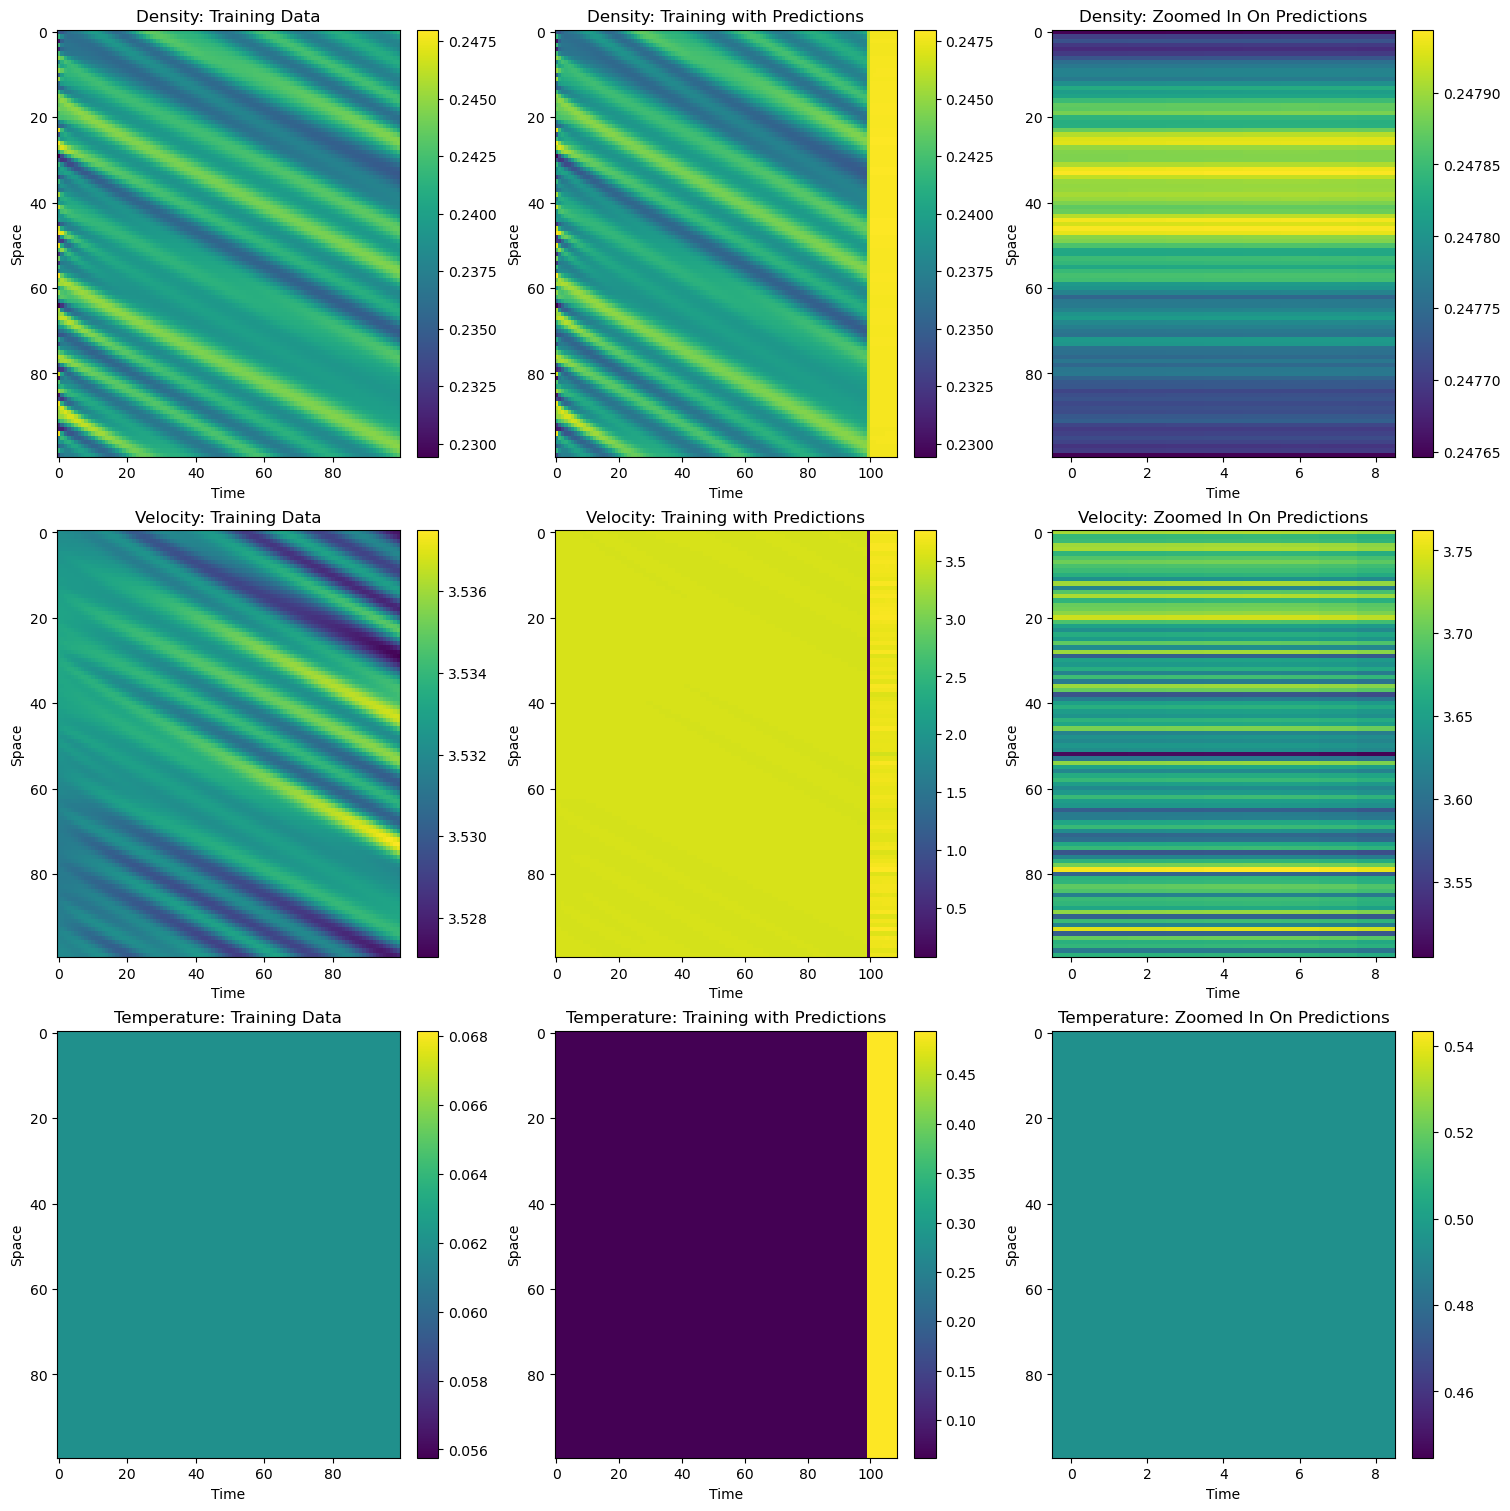

In [268]:
#####################################
### Forecast Using One Step Ahead ###
#####################################


# One Step Ahead
def forecast_snapshots(model, initial_data, future_snapshots, num_instances, num_fields, num_train_snapshots, num_points):
    # Initialize output_data to include training snapshots and space for future predictions
    output_data = np.zeros((num_instances, num_train_snapshots + future_snapshots, num_fields, num_points))
    
    # Copy the training data into the output_data array
    output_data[:, :num_train_snapshots, :, :] = initial_data

    # We use only the last 'past_steps' snapshots to predict the next snapshot
    for i in range(future_snapshots):
        # Using the last 'past_steps' snapshots as input for the model
        new_input = output_data[:, num_train_snapshots + i - past_steps:num_train_snapshots + i, :, :]
        new_input_reshaped = new_input.reshape(num_instances, past_steps, num_fields * num_points)
        
        # Predicting the next snapshot
        next_snapshot = model.predict(new_input_reshaped)
        
        # Reshaping the predicted snapshot to fit the output_data array
        next_snapshot_reshaped = next_snapshot.reshape(num_instances, num_fields, num_points)
        
        # Inserting the predicted snapshot into the next position in the output_data array
        if num_train_snapshots + i < output_data.shape[1] - 1:
            output_data[:, num_train_snapshots + i + 1, :, :] = next_snapshot_reshaped

    return output_data

# Numer of snapshots to forecast
future_snapshots = 10

# Using normalized input data and multiplying by std and adding mean for denormalization
forecasted_data_normalized = forecast_snapshots(model, train_data_normalized, future_snapshots, num_instances, num_fields, num_train_snapshots, num_points)
forecasted_data = forecasted_data_normalized * std + mean

# Transpose forecasted_data to match the dimension order of original_data
forecasted_data = np.transpose(forecasted_data, (0, 2, 1, 3))  # Shape: (num_instances, num_fields, num_train_snapshots + future_snapshots, num_points)

###################################
### Visualize Model Predictions ###
###################################

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), constrained_layout=True)
fields = ['Density', 'Velocity', 'Temperature']
instance_idx = 123

for i, field in enumerate(fields):
    # Plot actual data
    ax = axes[i, 0]
    cax = ax.imshow(original_data[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training Data')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot data with predictions
    ax = axes[i, 1]
    cax = ax.imshow(forecasted_data[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training with Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot only predicted data
    ax = axes[i, 2]
    cax = ax.imshow(forecasted_data[instance_idx, i, num_snapshots:, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Zoomed In On Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

plt.show()

# Still not working